#The first model

In [ ]:
import pandas as pd

df = pd.read_csv("/content/SalaryPrediction.csv")
if "Club" not in df.columns or "Wage" not in df.columns or "League" not in df.columns:
    raise ValueError("Dataset must contain 'Club', 'Wage', and 'League' columns")

df["Wage"] = df["Wage"].astype(str).str.replace(r'[^0-9.]', '', regex=True)

df["Wage"] = pd.to_numeric(df["Wage"], errors='coerce')

df = df.dropna(subset=["Wage"])

df = df.groupby(["Club", "League"])["Wage"].sum().reset_index()

df.rename(columns={"Wage": "Total Wage"}, inplace=True)

df.to_csv("team_salaries.csv", index=False)

print(df.head())

         Club             League  Total Wage
0  1. FC Koln         Bundesliga    20474500
1   A. Bilbao            La Liga    47020000
2   A. Madrid            La Liga   139273000
3  AC Ajaccio  Ligue 1 Uber Eats     7532500
4  AJ Auxerre  Ligue 1 Uber Eats     8193000


In [ ]:
import pandas as pd

file_path = "/content/team_salaries_new.xlsx"

df_salaries = pd.read_excel(file_path, sheet_name="team_salaries")
df_standings = pd.read_excel(file_path, sheet_name="All_leagues")

df_standings.rename(columns={"Team": "Club"}, inplace=True)

merged_df = pd.merge(df_salaries, df_standings, on= "Club", how="right")

merged_df.drop(columns = ["League_y"], inplace = True)
merged_df.rename(columns = {"League_x": "League"}, inplace = True)
merged_df.head()
merged_df.to_excel("team_salaries_final.xlsx", index=False)

##Model training

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers

df_teams = pd.read_excel("/content/team_salaries_final.xlsx")

X = df_teams[["Total Wage", "Points", "plus-minus"]]
y = df_teams["Place "]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = keras.Sequential([
    layers.Dense(64, activation="relu", input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation="relu"),
    layers.Dense(1, activation="linear")
])

model.compile(optimizer="adam", loss="mse", metrics=["mae"])

model.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_test, y_test), verbose=1)

loss, mae = model.evaluate(X_test, y_test)
print(f"Model MAE: {mae:.2f}")

df_teams["Predicted Place"] = model.predict(X_scaled)

top_6_teams = df_teams[df_teams["Predicted Place"] <= 6]
mlp_wage_threshold = top_6_teams["Total Wage"].min()

print(f"Estimated Minimum Wage for Top 6 Finish: {mlp_wage_threshold:,.0f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 116.3680 - mae: 9.1009 - val_loss: 114.9874 - val_mae: 9.4009
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 129.3009 - mae: 9.8270 - val_loss: 107.5030 - val_mae: 9.0882
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 117.1596 - mae: 9.3759 - val_loss: 98.8149 - val_mae: 8.7072
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 104.0994 - mae: 8.7515 - val_loss: 87.5794 - val_mae: 8.1871
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 83.4416 - mae: 7.6927 - val_loss: 73.8138 - val_mae: 7.6118
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 83.0438 - mae: 8.0957 - val_loss: 57.0854 - val_mae: 6.7842
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 47.6881 - mae: 5.7913 - val_loss: 40.8190 - val_mae: 5.7831
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 41.4094 - mae: 5.5042 - val_loss: 24.8219 - val_mae: 4.4942
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 

##Evaluating

In [ ]:
from sklearn.metrics import r2_score

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
R² Score: 0.93


In [ ]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.2f}")

RMSE: 1.35


In [ ]:
mape = np.mean(np.abs((y_test - y_pred.flatten()) / y_test)) * 100
print(f"MAPE: {mape:.2f}%")

MAPE: 17.75%


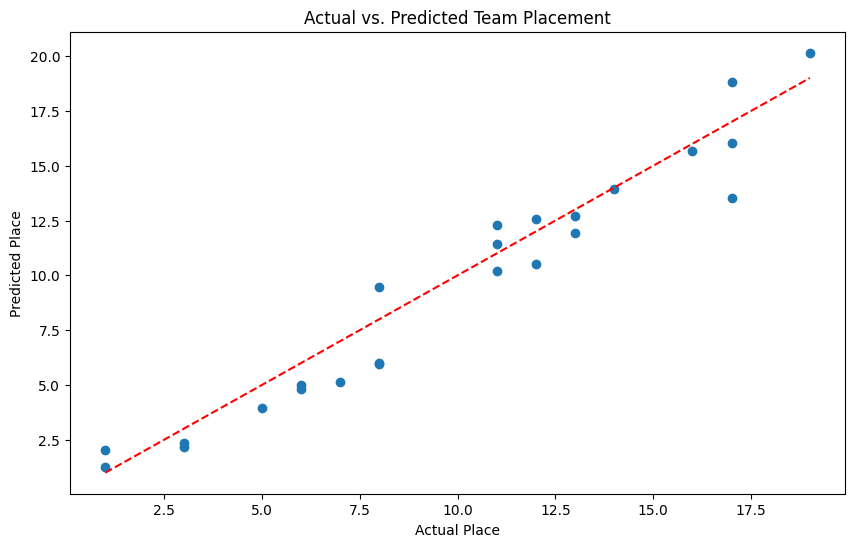

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="--")
plt.xlabel("Actual Place")
plt.ylabel("Predicted Place")
plt.title("Actual vs. Predicted Team Placement")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


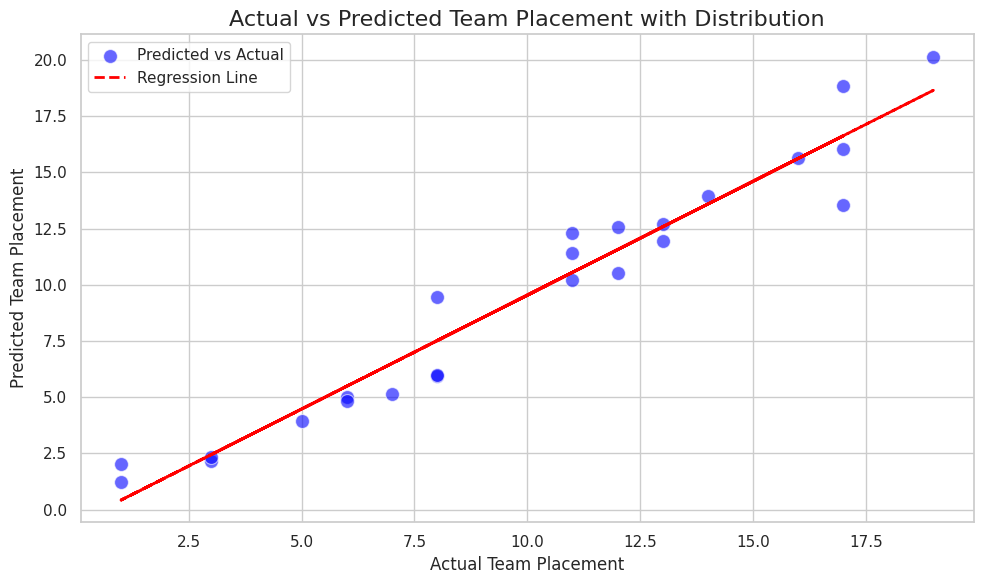

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression

y_pred = model.predict(X_test)

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

sns.scatterplot(x=y_test, y=y_pred.flatten(), color='blue', label="Predicted vs Actual", alpha=0.6, s=100)

regressor = LinearRegression()
regressor.fit(y_test.values.reshape(-1, 1), y_pred.flatten())
y_reg_line = regressor.predict(y_test.values.reshape(-1, 1))
plt.plot(y_test, y_reg_line, color='red', linestyle='--', label="Regression Line", linewidth=2)

plt.title("Actual vs Predicted Team Placement with Distribution", fontsize=16)
plt.xlabel("Actual Team Placement", fontsize=12)
plt.ylabel("Predicted Team Placement", fontsize=12)
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

##Percentile calculation and visualisation

In [ ]:
import numpy as np
percentile_threshold = 85

dynamic_wage_threshold = np.percentile(df_teams["Total Wage"], percentile_threshold)

print(f"Dynamic Wage Threshold (21th percentile): {dynamic_wage_threshold:,.2f}")

Dynamic Wage Threshold (21th percentile): 85,423,500.00


In [ ]:
wage_threshold = 85423500

teams_below_threshold = df_teams[df_teams["Total Wage"] < wage_threshold]

print(f"Teams with wage below {wage_threshold:,}:")
print(teams_below_threshold[["Club", "Total Wage", "Place ", "Predicted Place"]])

teams_below_threshold_in_top_6 = teams_below_threshold[teams_below_threshold["Predicted Place"] <= 6]

print(f"\nTeams with wage below {wage_threshold:,} and predicted to be in Top 6:")
print(teams_below_threshold_in_top_6[["Club", "Total Wage", "Predicted Place"]])

Teams with wage below 85,423,500:
               Club  Total Wage  Place   Predicted Place
8          Brighton    43433000       9        10.389611
9            Wolves    73379500      10        10.757077
11   Crystal Palace    69986500      12        10.507403
12        Brentford    46211000      13        11.928403
13      Aston Villa    83997000      14        12.124523
..              ...         ...     ...              ...
111             VIZ     2694250      14        14.759841
112          Arouca     2165000      15        15.609671
113        Casa Pia     2570250      16        15.027032
114          Chaves     2623000      17        16.520285
115         Rio Ave     2666500      18        17.851480

[98 rows x 4 columns]

Teams with wage below 85,423,500 and predicted to be in Top 6:
              Club  Total Wage  Predicted Place
23         Sevilla    53360000         3.605542
24   Real Hispalis    38140500         4.587264
26      Villarreal    35276000         5.135348
40 

###21%

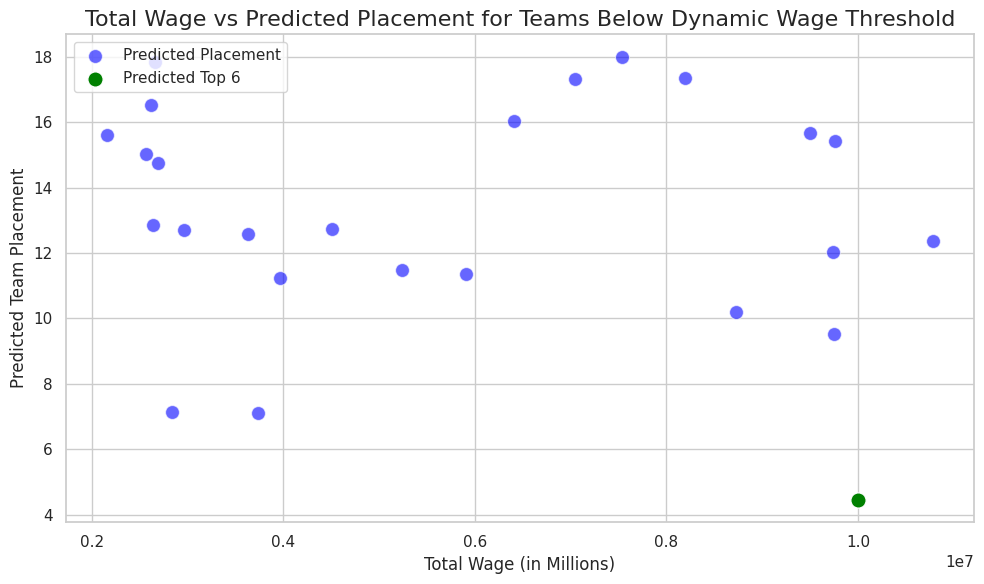

In [ ]:
plt.figure(figsize=(10, 6))

sns.scatterplot(x=teams_below_threshold["Total Wage"], y=teams_below_threshold["Predicted Place"], color='blue', label="Predicted Placement", alpha=0.6, s=100)

if not teams_below_threshold_in_top_6.empty:
    sns.scatterplot(x=teams_below_threshold_in_top_6["Total Wage"], y=teams_below_threshold_in_top_6["Predicted Place"], color='green', label="Predicted Top 6", s=120)

plt.title("Total Wage vs Predicted Placement for Teams Below Dynamic Wage Threshold", fontsize=16)
plt.xlabel("Total Wage (in Millions)", fontsize=12)
plt.ylabel("Predicted Team Placement", fontsize=12)
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

###40%

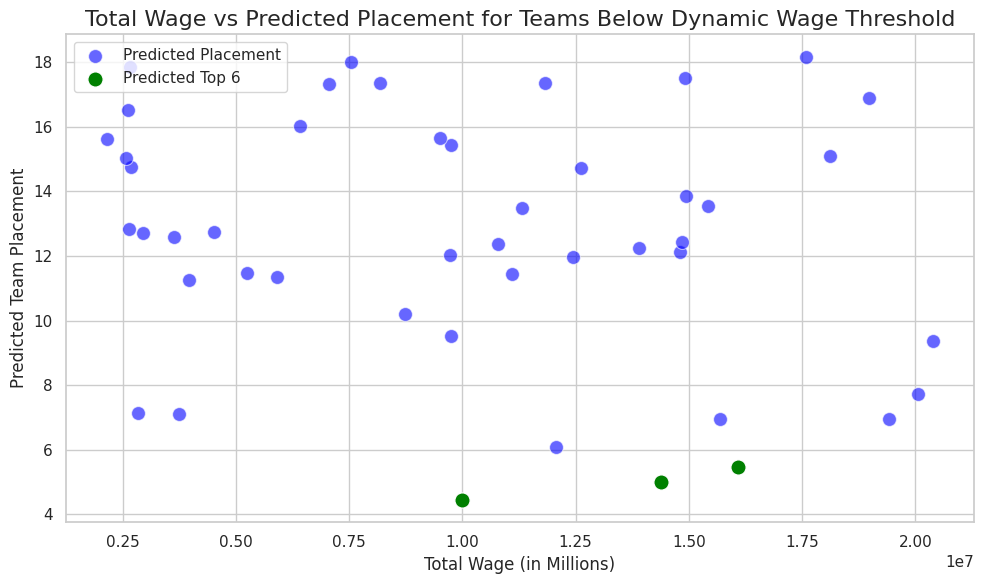

In [ ]:
plt.figure(figsize=(10, 6))

sns.scatterplot(x=teams_below_threshold["Total Wage"], y=teams_below_threshold["Predicted Place"], color='blue', label="Predicted Placement", alpha=0.6, s=100)

if not teams_below_threshold_in_top_6.empty:
    sns.scatterplot(x=teams_below_threshold_in_top_6["Total Wage"], y=teams_below_threshold_in_top_6["Predicted Place"], color='green', label="Predicted Top 6", s=120)

plt.title("Total Wage vs Predicted Placement for Teams Below Dynamic Wage Threshold", fontsize=16)
plt.xlabel("Total Wage (in Millions)", fontsize=12)
plt.ylabel("Predicted Team Placement", fontsize=12)
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

###60%

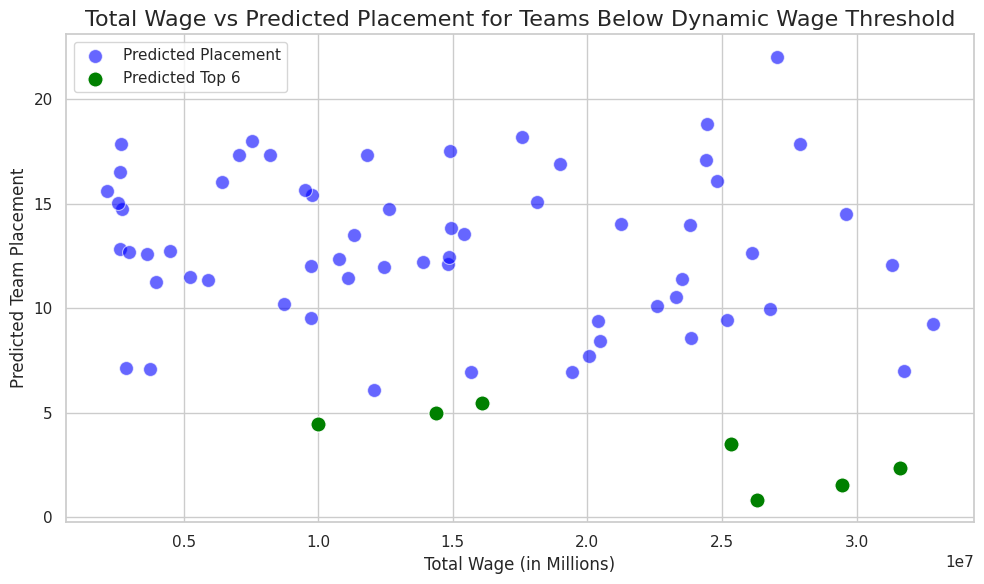

In [ ]:
plt.figure(figsize=(10, 6))

sns.scatterplot(x=teams_below_threshold["Total Wage"], y=teams_below_threshold["Predicted Place"], color='blue', label="Predicted Placement", alpha=0.6, s=100)

if not teams_below_threshold_in_top_6.empty:
    sns.scatterplot(x=teams_below_threshold_in_top_6["Total Wage"], y=teams_below_threshold_in_top_6["Predicted Place"], color='green', label="Predicted Top 6", s=120)

plt.title("Total Wage vs Predicted Placement for Teams Below Dynamic Wage Threshold", fontsize=16)
plt.xlabel("Total Wage (in Millions)", fontsize=12)
plt.ylabel("Predicted Team Placement", fontsize=12)
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

###85%

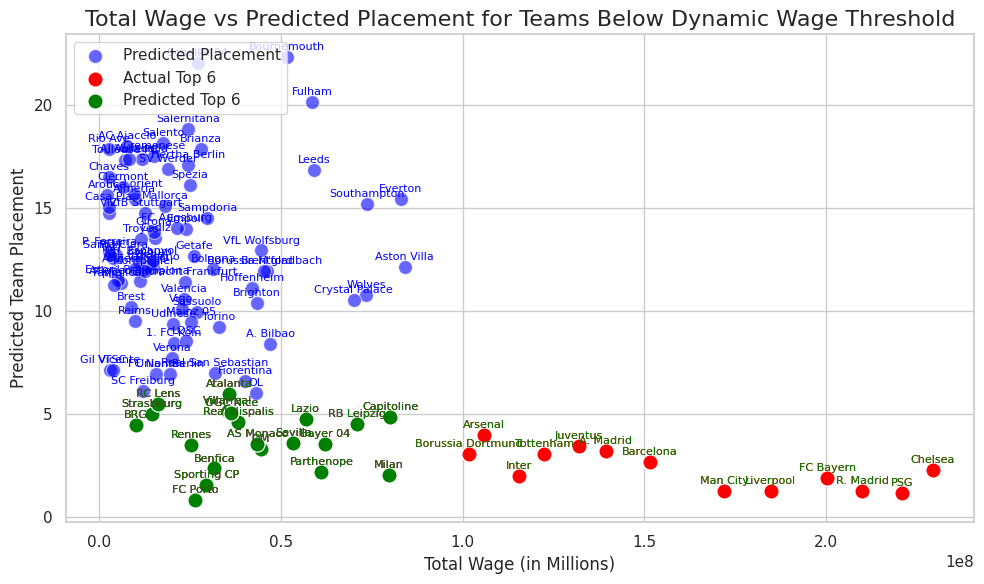

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

sns.scatterplot(x=teams_below_threshold["Total Wage"], y=teams_below_threshold["Predicted Place"], color='blue', label="Predicted Placement", alpha=0.6, s=100)


sns.scatterplot(x=top_6_teams["Total Wage"],
                y=top_6_teams["Predicted Place"],
                color='red', label="Actual Top 6", s=120)

if not teams_below_threshold_in_top_6.empty:
    sns.scatterplot(x=teams_below_threshold_in_top_6["Total Wage"], y=teams_below_threshold_in_top_6["Predicted Place"], color='green', label="Predicted Top 6", s=120)

for index, row in teams_below_threshold.iterrows():
    plt.annotate(row['Club'],
                 (row['Total Wage'], row['Predicted Place']),
                 textcoords="offset points",
                 xytext=(0, 5),
                 ha='center',
                 fontsize=8,
                 color='blue')

for index, row in top_6_teams.iterrows():
    plt.annotate(row['Club'],
                 (row['Total Wage'], row['Predicted Place']),
                 textcoords="offset points",
                 xytext=(0, 5),
                 ha='center',
                 fontsize=8,
                 color='red')

predicted_top_6_teams = df_teams[df_teams["Predicted Place"] <= 6]
for index, row in predicted_top_6_teams.iterrows():
    plt.annotate(row['Club'],
                 (row['Total Wage'], row['Predicted Place']),
                 textcoords="offset points",
                 xytext=(0, 5),
                 ha='center',
                 fontsize=8,
                 color='green')

plt.title("Total Wage vs Predicted Placement for Teams Below Dynamic Wage Threshold", fontsize=16)
plt.xlabel("Total Wage (in Millions)", fontsize=12)
plt.ylabel("Predicted Team Placement", fontsize=12)
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

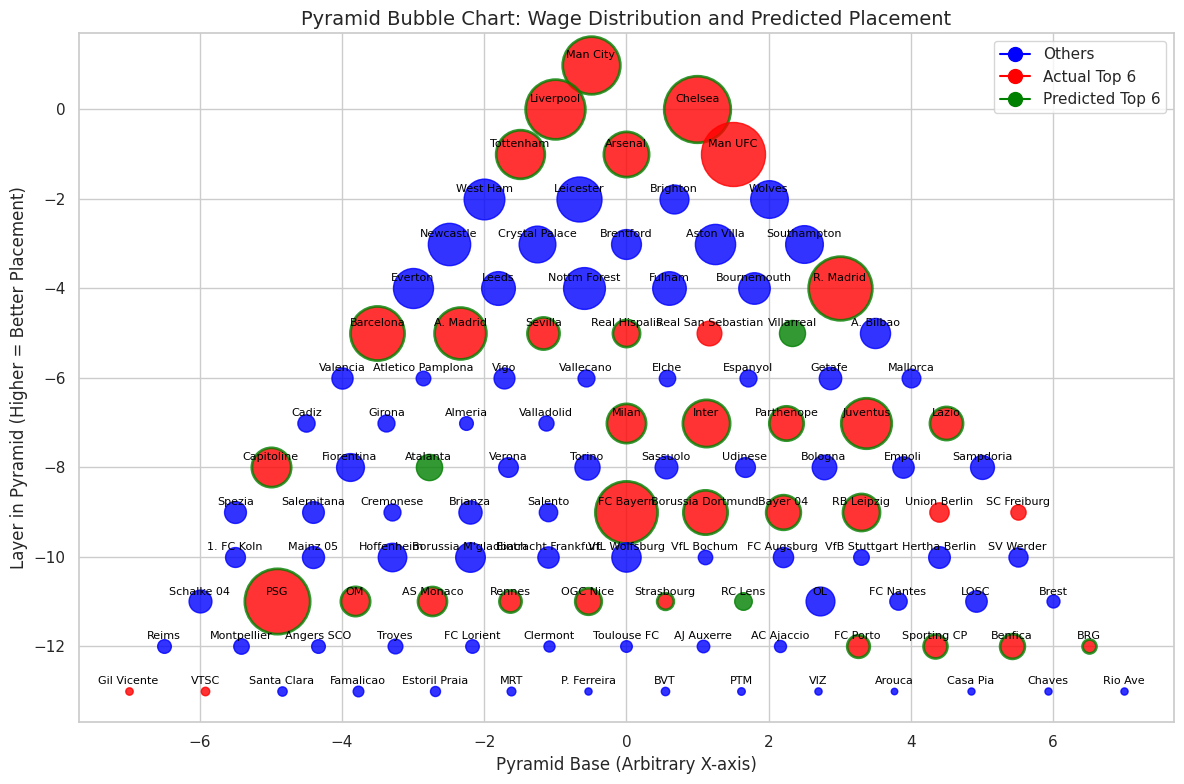

In [ ]:
teams_sorted = df_teams.sort_values(by="Place ", ascending=True)

pyramid_structure = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 11, 12, 13, 14]

x_positions = []
y_positions = []
current_y = 1
start_x = 0

team_index = 0

for num_teams in pyramid_structure:
    row_x_positions = np.linspace(start_x - (num_teams / 2), start_x + (num_teams / 2), num_teams)
    x_positions.extend(row_x_positions)
    y_positions.extend([current_y] * num_teams)
    current_y -= 1
    team_index += num_teams
    if team_index >= len(teams_sorted):
        break

teams_sorted = teams_sorted.iloc[:len(x_positions)]

plt.figure(figsize=(12, 8))

for i, row in teams_sorted.iterrows():
    if row["Place "] <= 6 and row["Predicted Place"] <= 6:
        plt.scatter(x_positions[i], y_positions[i],
                    s=row["Total Wage"]/100000, alpha=0.8, c="red", edgecolors="green", linewidth=2)
    elif row["Place "] <= 6:
        plt.scatter(x_positions[i], y_positions[i],
                    s=row["Total Wage"]/100000, alpha=0.8, c="red")
    elif row["Predicted Place"] <= 6:
        plt.scatter(x_positions[i], y_positions[i],
                    s=row["Total Wage"]/100000, alpha=0.8, c="green")
    else:
        plt.scatter(x_positions[i], y_positions[i],
                    s=row["Total Wage"]/100000, alpha=0.8, c="blue")

for i, row in teams_sorted.iterrows():
    plt.annotate(row['Club'],
                 (x_positions[i], y_positions[i]),
                 textcoords="offset points",
                 xytext=(0, 5),
                 ha='center',
                 fontsize=8,
                 color='black')

plt.title("Pyramid Bubble Chart: Wage Distribution and Predicted Placement", fontsize=14)
plt.xlabel("Pyramid Base (Arbitrary X-axis)", fontsize=12)
plt.ylabel("Layer in Pyramid (Higher = Better Placement)", fontsize=12)

plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='blue', label='Others', markersize=10),
    plt.Line2D([0], [0], marker='o', color='red', label='Actual Top 6', markersize=10),
    plt.Line2D([0], [0], marker='o', color='green', label='Predicted Top 6', markersize=10)
])

plt.tight_layout()
plt.show()

In [ ]:
teams_sorted[teams_sorted['Club']=='Villarreal']

,Club,League,Total Wage,Place,Points,plus-minus,Predicted Place
26,Villarreal,La Liga,35276000,7,59,26,5.135348


#The second model

In [ ]:
players_per_team = df.groupby("Club")["Wage"].count()

average_player_wage = pd.merge(df_teams[['Club', 'Total Wage']], players_per_team, on='Club')
average_player_wage['Average Player Wage'] = average_player_wage['Total Wage'] / average_player_wage['Wage']

average_player_wage["Above Threshold"] = average_player_wage["Average Player Wage"] > team_wage_threshold

print(average_player_wage.head())

        Club  Total Wage  Wage  Average Player Wage  Above Threshold
0   Man City   171995000    38         4.526184e+06            False
1  Liverpool   184684000    51         3.621255e+06            False
2    Chelsea   229318000    54         4.246630e+06            False
3  Tottenham   122478000    43         2.848326e+06            False
4    Arsenal   105908000    40         2.647700e+06            False


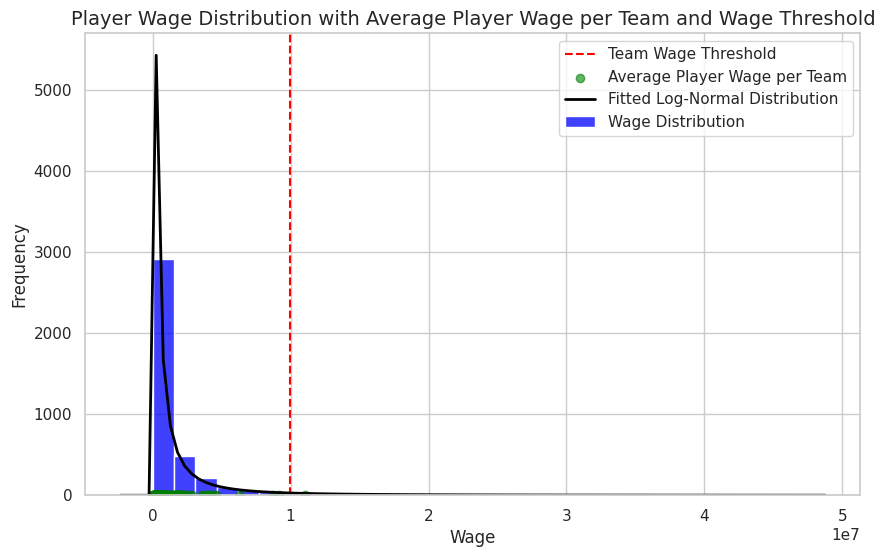

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Wage'], kde=False, bins=30, color='blue', label='Wage Distribution')

plt.axvline(team_wage_threshold, color='red', linestyle='--', label="Team Wage Threshold")

plt.scatter(average_player_wage['Average Player Wage'], np.zeros_like(average_player_wage['Average Player Wage']),
            color='green', label="Average Player Wage per Team", alpha=0.6)

x = np.linspace(xmin, xmax, 100)
p_lognorm = lognorm.pdf(x, shape, loc, scale)
plt.plot(x, p_lognorm * len(df) * (xmax - xmin) / 30, 'black', linewidth=2, label="Fitted Log-Normal Distribution")

plt.title("Player Wage Distribution with Average Player Wage per Team and Wage Threshold", fontsize=14)
plt.xlabel('Wage')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

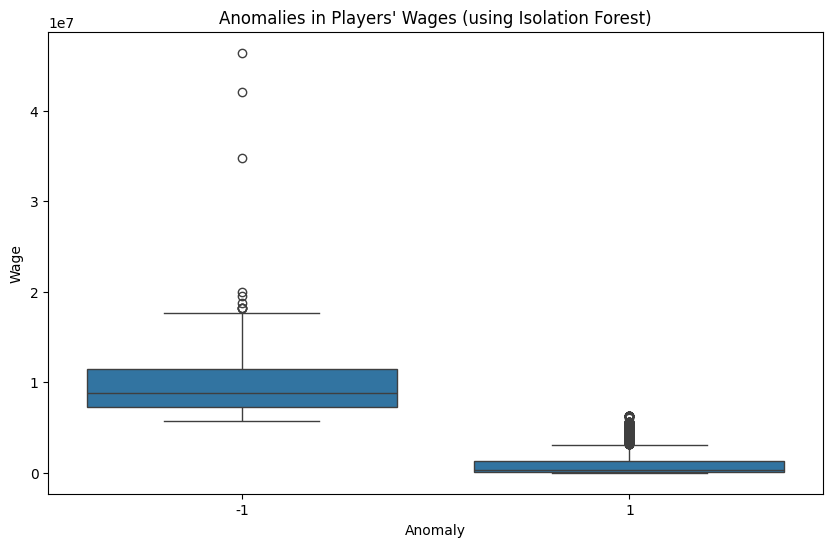

Anomalies Detected:         Club      Wage
0        PSG  46427000
1        PSG  42125000
2        PSG  34821000
3  R. Madrid  19959000
4    Man UFC  19500000


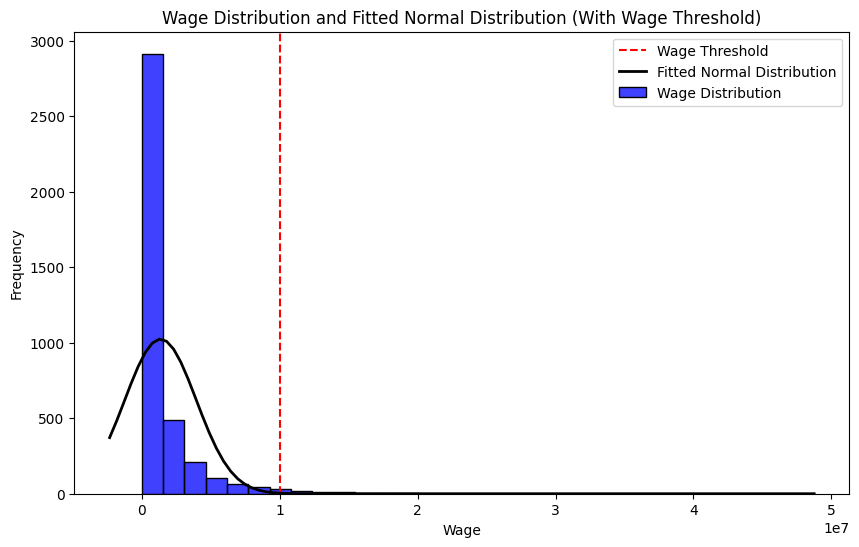

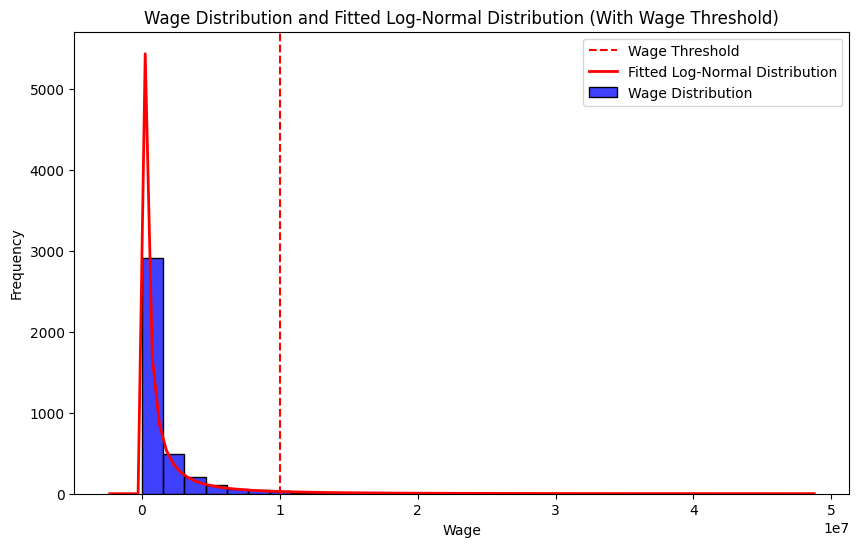

Normal Distribution: mu=1367959.3678013822, std=2589525.2990160594
Log-normal Distribution: shape=1.8631329016040552, loc=0, scale=342766.7348984983


In [ ]:
from sklearn.ensemble import IsolationForest
from scipy.stats import norm, lognorm

team_wage_threshold = 9994501

df = pd.read_excel("/content/players_wage_data.xlsx")

df['Wage'] = pd.to_numeric(df['Wage'], errors='coerce')
df = df.dropna(subset=['Wage'])

df['Wage Category'] = np.where(df['Wage'] >= team_wage_threshold, 'Above Threshold', 'Below Threshold')

X = df[['Wage']]
model = IsolationForest(contamination=0.05, random_state=42)
df['Anomaly'] = model.fit_predict(X)

plt.figure(figsize=(10, 6))
sns.boxplot(x='Anomaly', y='Wage', data=df)
plt.title("Anomalies in Players' Wages (using Isolation Forest)")
plt.show()

anomalies = df[df['Anomaly'] == -1]
print(f"Anomalies Detected: {anomalies[['Club', 'Wage']].head()}")

mu, std = norm.fit(df['Wage'])

plt.figure(figsize=(10, 6))
sns.histplot(df['Wage'], kde=False, bins=30, color='blue', label='Wage Distribution')

plt.axvline(team_wage_threshold, color='red', linestyle='--', label="Wage Threshold")

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p * len(df) * (xmax - xmin) / 30, 'k', linewidth=2, label="Fitted Normal Distribution")

plt.title("Wage Distribution and Fitted Normal Distribution (With Wage Threshold)")
plt.xlabel('Wage')
plt.ylabel('Frequency')
plt.legend()
plt.show()

shape, loc, scale = lognorm.fit(df['Wage'], floc=0)

plt.figure(figsize=(10, 6))
sns.histplot(df['Wage'], kde=False, bins=30, color='blue', label='Wage Distribution')

plt.axvline(team_wage_threshold, color='red', linestyle='--', label="Wage Threshold")

x = np.linspace(xmin, xmax, 100)
p_lognorm = lognorm.pdf(x, shape, loc, scale)
plt.plot(x, p_lognorm * len(df) * (xmax - xmin) / 30, 'r', linewidth=2, label="Fitted Log-Normal Distribution")

plt.title("Wage Distribution and Fitted Log-Normal Distribution (With Wage Threshold)")
plt.xlabel('Wage')
plt.ylabel('Frequency')
plt.legend()
plt.show()

print(f"Normal Distribution: mu={mu}, std={std}")
print(f"Log-normal Distribution: shape={shape}, loc={loc}, scale={scale}")

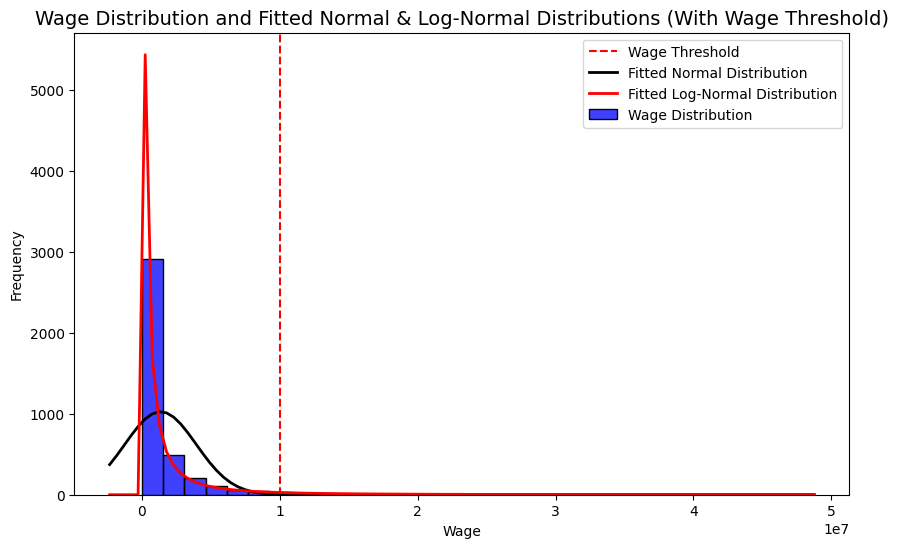

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Wage'], kde=False, bins=30, color='blue', label='Wage Distribution')

plt.axvline(team_wage_threshold, color='red', linestyle='--', label="Wage Threshold")

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p * len(df) * (xmax - xmin) / 30, 'k', linewidth=2, label="Fitted Normal Distribution")

p_lognorm = lognorm.pdf(x, shape, loc, scale)
plt.plot(x, p_lognorm * len(df) * (xmax - xmin) / 30, 'r', linewidth=2, label="Fitted Log-Normal Distribution")

plt.title("Wage Distribution and Fitted Normal & Log-Normal Distributions (With Wage Threshold)", fontsize=14)
plt.xlabel('Wage')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
from scipy.stats import zscore

df['Z-Score'] = zscore(df['Wage'])

threshold = 3
df['Anomaly_Z-Score'] = df['Z-Score'].apply(lambda x: x > threshold or x < -threshold)

Q1 = df['Wage'].quantile(0.25)
Q3 = df['Wage'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df['Anomaly_IQR'] = df['Wage'].apply(lambda x: x < lower_bound or x > upper_bound)

anomalies = df[(df['Anomaly_Z-Score']) | (df['Anomaly_IQR'])]

print(anomalies[['Club', 'Wage', 'Anomaly_Z-Score', 'Anomaly_IQR']])

                    Club      Wage  Anomaly_Z-Score  Anomaly_IQR
0                    PSG  46427000             True         True
1                    PSG  42125000             True         True
2                    PSG  34821000             True         True
3              R. Madrid  19959000             True         True
4                Man UFC  19500000             True         True
..                   ...       ...              ...          ...
381            Barcelona   3869000            False         True
382  Borussia M'gladbach   3869000            False         True
383                  PSG   3869000            False         True
384             Bayer 04   3869000            False         True
385           Capitoline   3828000            False         True

[386 rows x 4 columns]


In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df, kde=True, color='blue', bins=30)
plt.title("Player Wage Distribution")
plt.xlabel("Player Wage")
plt.ylabel("Frequency")

mu, std = norm.fit(df['Wage'])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p * len(df) * (xmax - xmin) / 30, 'k', linewidth=2, label="Normal Fit")

shape, loc, scale = lognorm.fit(df['Wage'], floc=0)
p_lognorm = lognorm.pdf(x, shape, loc, scale)
plt.plot(x, p_lognorm * len(df) * (xmax - xmin) / 30, 'r', linewidth=2, label="Log-Normal Fit")

plt.legend()
plt.show()

print(f"Normal Distribution Parameters: mu = {mu}, std = {std}")
print(f"Log-Normal Distribution Parameters: shape = {shape}, scale = {scale}")

SyntaxError: invalid syntax. Perhaps you forgot a comma? (<ipython-input-17-ce1c4de1e164>, line 13)

###Probability for normal and log-normal distributions

In [ ]:
df['Normal_Probability'] = norm.pdf(df['Wage'], mu, std)

df['Anomaly_Normal'] = df['Normal_Probability'].apply(lambda x: x < 0.01)

normal_anomalies = df[df['Anomaly_Normal']]
print("Normal Distribution Anomalies:")
print(normal_anomalies[['Club', 'Wage', 'Normal_Probability']])

Normal Distribution Anomalies:
           Club      Wage  Normal_Probability
0           PSG  46427000        2.756743e-73
1           PSG  42125000        2.485952e-61
2           PSG  34821000        8.870329e-44
3     R. Madrid  19959000        9.893203e-19
4       Man UFC  19500000        3.476782e-18
...         ...       ...                 ...
3902       Vigo      3400        1.340888e-07
3903  Famalicao      3200        1.340833e-07
3904       Vigo      2900        1.340751e-07
3905       Vigo      2700        1.340697e-07
3906       Vigo      1400        1.340342e-07

[3907 rows x 3 columns]


In [ ]:
df['LogNormal_Probability'] = lognorm.pdf(df['Wage'], shape, loc=0, scale=scale)

df['Anomaly_LogNormal'] = df['LogNormal_Probability'].apply(lambda x: x < 0.01)

lognormal_anomalies = df[df['Anomaly_LogNormal']]
print("Log-Normal Distribution Anomalies:")
print(lognormal_anomalies[['Club', 'Wage', 'LogNormal_Probability']])

Log-Normal Distribution Anomalies:
           Club      Wage  LogNormal_Probability
0           PSG  46427000           1.434385e-10
1           PSG  42125000           1.811431e-10
2           PSG  34821000           2.838420e-10
3     R. Madrid  19959000           9.934732e-10
4       Man UFC  19500000           1.044858e-09
...         ...       ...                    ...
3902       Vigo      3400           2.936694e-06
3903  Famalicao      3200           2.877178e-06
3904       Vigo      2900           2.776828e-06
3905       Vigo      2700           2.701454e-06
3906       Vigo      1400           1.958085e-06

[3907 rows x 3 columns]


###Anomalies

In [ ]:
df['Normal_Anomaly'] = df['Normal_Probability'].apply(lambda x: x < 0.01)

df['LogNormal_Anomaly'] = df['LogNormal_Probability'].apply(lambda x: x < 0.01)

In [ ]:
team_anomalies = df.groupby('Club')[['Normal_Anomaly', 'LogNormal_Anomaly']].sum()

team_anomalies['Total_Anomalies'] = team_anomalies['Normal_Anomaly'] + team_anomalies['LogNormal_Anomaly']

df_teams_with_anomalies = df_teams.merge(team_anomalies, left_on='Club', right_index=True, how='left')

df_teams_with_anomalies['Total_Anomalies'].fillna(0, inplace=True)

print(df_teams_with_anomalies[['Club', 'Place ', 'Total_Anomalies']])

          Club  Place   Total_Anomalies
0     Man City       1               76
1    Liverpool       2              102
2      Chelsea       3              108
3    Tottenham       4               86
4      Arsenal       5               80
..         ...     ...              ...
111        VIZ      14              114
112     Arouca      15               54
113   Casa Pia      16               60
114     Chaves      17               46
115    Rio Ave      18               78

[116 rows x 3 columns]


<ipython-input-18-dcf0e43e2161>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_teams_with_anomalies['Total_Anomalies'].fillna(0, inplace=True)


In [ ]:
correlation = df_teams_with_anomalies[['Total_Anomalies', 'Place ']].corr()

print("Correlation between anomalies and team placement:")
print(correlation)

Correlation between anomalies and team placement:
                 Total_Anomalies    Place 
Total_Anomalies         1.000000 -0.082769
Place                  -0.082769  1.000000


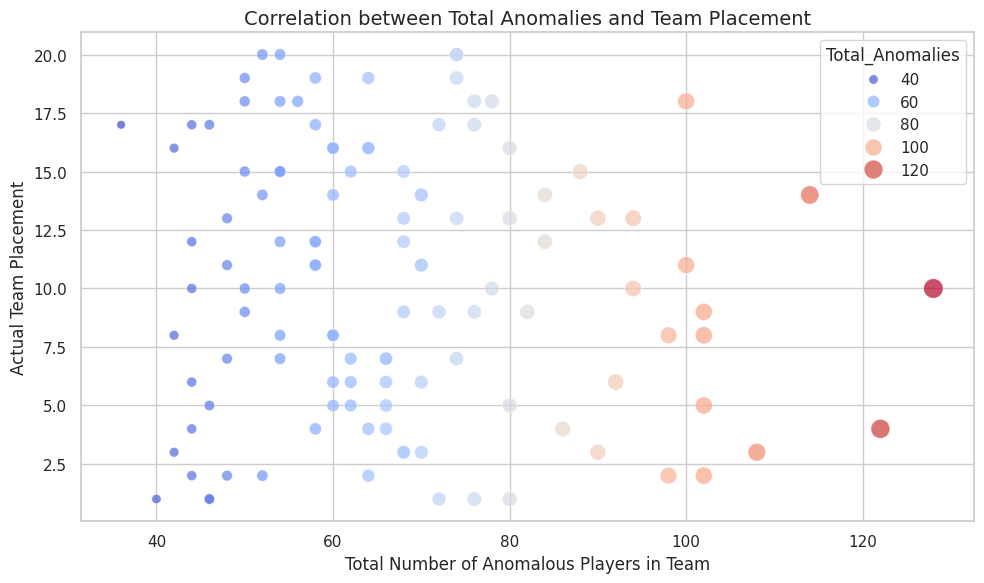

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Total_Anomalies', y='Place ', data=df_teams_with_anomalies,
                hue='Total_Anomalies', palette='coolwarm', alpha=0.7, size='Total_Anomalies', sizes=(40, 200))

plt.title('Correlation between Total Anomalies and Team Placement', fontsize=14)
plt.xlabel('Total Number of Anomalous Players in Team', fontsize=12)
plt.ylabel('Actual Team Placement', fontsize=12)

plt.tight_layout()
plt.show()

##Model of anomalies affection

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


X = df_players_with_club_info[['Total Wage', 'Points', 'plus-minus','Total_Anomalies', 'LogNormal_Anomaly', 'Wage', 'Age', 'Apps', 'Caps', ]]
y = df_players_with_club_info['Place ']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2010)

mlp_model = MLPRegressor(max_iter=500, random_state=2010)

param_grid_mlp = {
    'hidden_layer_sizes': [(100,), (100, 50), (100, 50, 25)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'invscaling', 'adaptive']
}

grid_search_mlp = GridSearchCV(estimator=mlp_model, param_grid=param_grid_mlp, cv=5, n_jobs=-1, verbose=2)
grid_search_mlp.fit(X_train, y_train)

print(f"Best Hyperparameters for MLP: {grid_search_mlp.best_params_}")

best_mlp_model = grid_search_mlp.best_estimator_

y_pred_mlp = best_mlp_model.predict(X_test)
mae_mlp = mean_absolute_error(y_test, y_pred_mlp)
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
r2_mlp = r2_score(y_test, y_pred_mlp)

print(f"MLP Regressor - MAE: {mae_mlp}, MSE: {mse_mlp}, R-squared: {r2_mlp}")

Fitting 5 folds for each of 162 candidates, totalling 810 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
90 fits failed out of a total of 810.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py", line 754, in fit
    return 

Best Hyperparameters for MLP: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant', 'solver': 'adam'}
MLP Regressor - MAE: 4.758782687834118, MSE: 30.570394694422756, R-squared: -0.0028212759185624048


In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X = df_players_with_club_info[['Total Wage', 'Delta_Anomalies', 'Wage', 'Age', 'Apps', 'Caps', ]]
y = df_players_with_club_info['Place ']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2010)

mlp_model = MLPRegressor(max_iter=500, random_state=2010)

param_grid_mlp = {
    'hidden_layer_sizes': [(100, 50)],
    'activation': ['tanh'],
    'solver': ['adam'],
    'alpha': [0.0001],
    'learning_rate': ['constant']
}

grid_search_mlp = GridSearchCV(estimator=mlp_model, param_grid=param_grid_mlp, cv=5, n_jobs=-1, verbose=2)
grid_search_mlp.fit(X_train, y_train)

print(f"Best Hyperparameters for MLP: {grid_search_mlp.best_params_}")

best_mlp_model = grid_search_mlp.best_estimator_

y_pred_mlp = best_mlp_model.predict(X_test)
mae_mlp = mean_absolute_error(y_test, y_pred_mlp)
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
r2_mlp = r2_score(y_test, y_pred_mlp)

print(f"MLP Regressor - MAE: {mae_mlp}, MSE: {mse_mlp}, R-squared: {r2_mlp}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Hyperparameters for MLP: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant', 'solver': 'adam'}
MLP Regressor - MAE: 4.755780719294233, MSE: 30.593637087088304, R-squared: -0.0035837118014239167


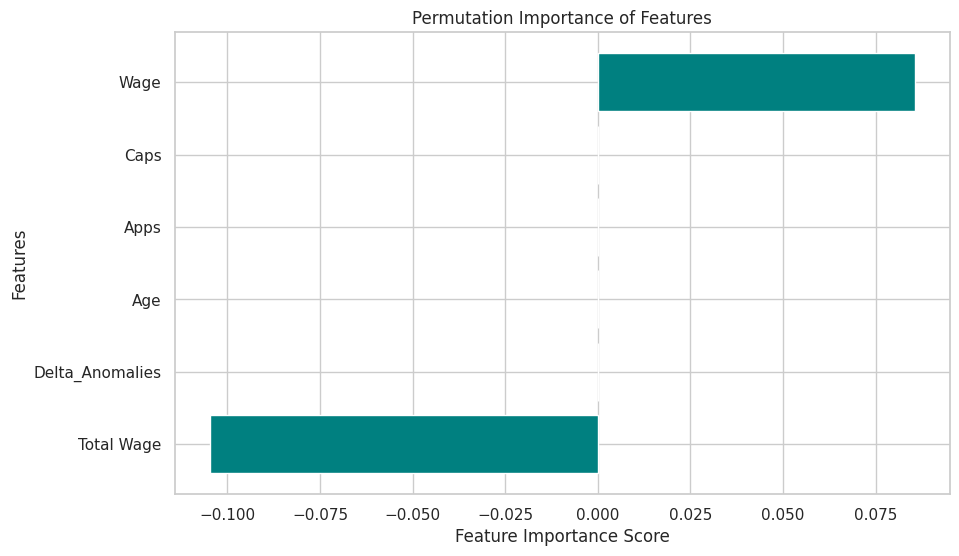

In [ ]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(best_mlp_model, X_test, y_test, scoring='neg_mean_absolute_error')

feature_names = df_players_with_club_info[['Total Wage', 'Delta_Anomalies', 'Wage', 'Age', 'Apps', 'Caps']].columns

sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(10, 6))
plt.barh(feature_names[sorted_idx], perm_importance.importances_mean[sorted_idx], color='teal')
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Permutation Importance of Features")
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
X = df_players_with_club_info[['Total Wage', 'Delta_Anomalies', 'Wage', 'Age', 'Apps', 'Caps']]
y = df_players_with_club_info['Place ']

scaler = StandardScaler()
X_train = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

model = Sequential()

model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=500, batch_size=32, verbose=1)

y_pred_dl = model.predict(X_test)

mae_dl = mean_absolute_error(y_test, y_pred_dl)
mse_dl = mean_squared_error(y_test, y_pred_dl)
r2_dl = r2_score(y_test, y_pred_dl)

print(f"Deep Learning Model - MAE: {mae_dl}, MSE: {mse_dl}, R-squared: {r2_dl}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 89.7039
Epoch 2/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 26.4999
Epoch 3/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21.7550
Epoch 4/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 20.3332
Epoch 5/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 18.0752
Epoch 6/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 17.2801
Epoch 7/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.4211
Epoch 8/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 16.7160
Epoch 9/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 16.2983
Epoch 10/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 15.4386
Epoch 11/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15.9735
Epoch 12/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 16.2916
Epoch 13/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15.4315
Epoch 14/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15.2147
Epoch 15/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
mape_dl = mean_absolute_percentage_error(y_test, y_pred_dl)
print(f"Deep Learning Model - MAPE: {mape_dl}")

Deep Learning Model - MAPE: 0.2207811325788498


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
25/25 ━

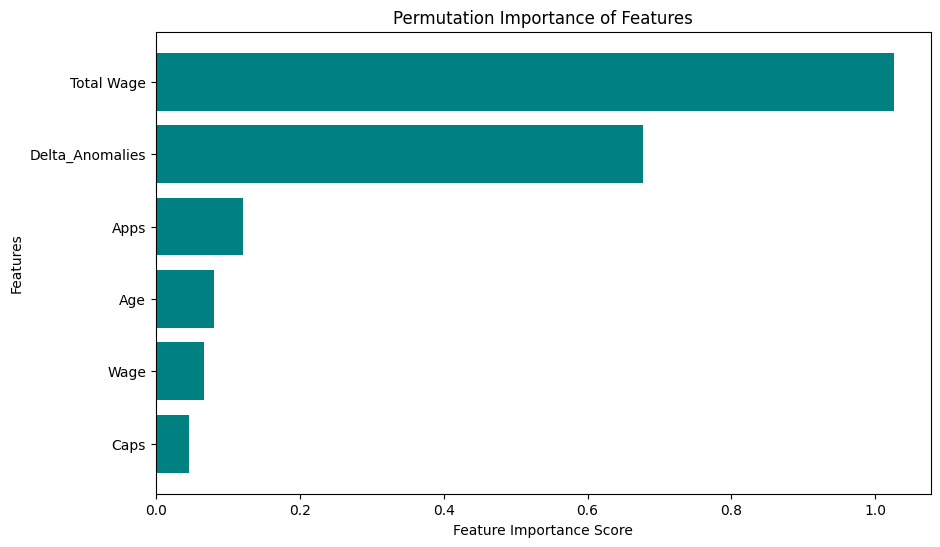

In [ ]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(model, X_test, y_test, scoring='neg_mean_absolute_percentage_error')

feature_names = df_players_with_club_info[['Total Wage', 'Delta_Anomalies', 'Wage', 'Age', 'Apps', 'Caps']].columns

sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(10, 6))
plt.barh(feature_names[sorted_idx], perm_importance.importances_mean[sorted_idx], color='teal')
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Permutation Importance of Features")
plt.show()

  0%|          | 0/782 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

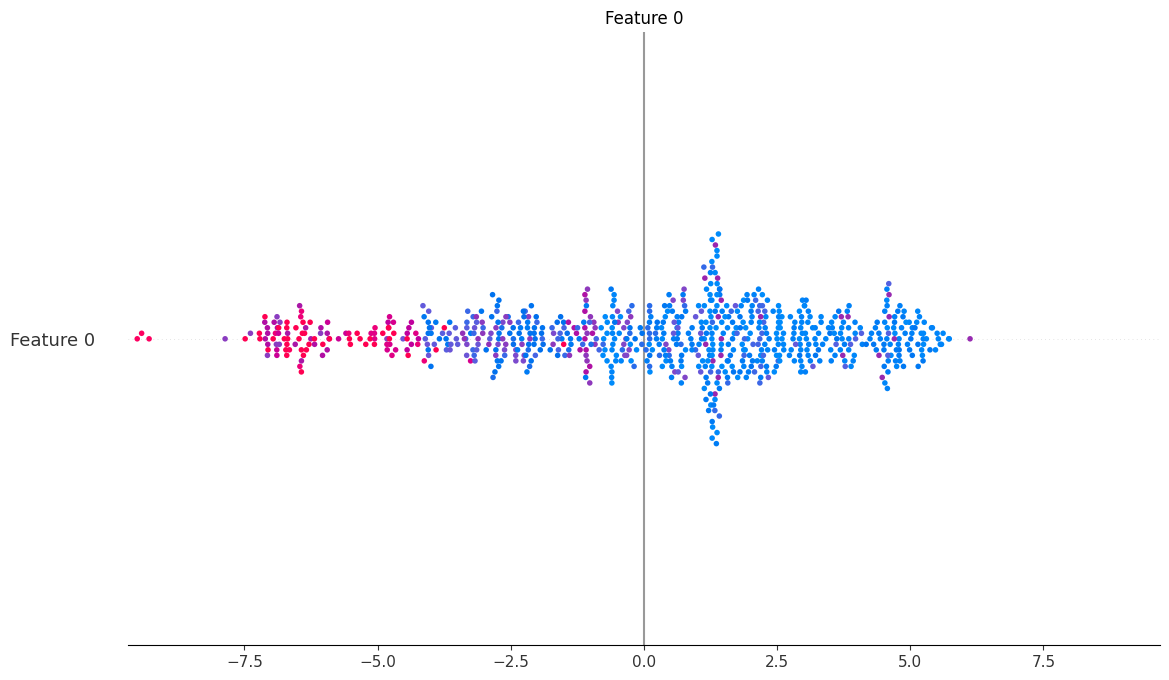

In [ ]:
import shap
explainer = shap.KernelExplainer(model, X_train)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

In [ ]:
shap.dependence_plot('Delta_Anomalies', shap_values, X_test)

ValueError: Could not find feature named: Delta_Anomalies

In [ ]:
shap_values_reshaped = shap_values.reshape(shap_values.shape[0], -1)
shap_values_df = pd.DataFrame(shap_values[:,:,0], columns=X.columns)
shap_values_df['Delta_Anomalies'].abs().mean()

np.float64(2.2058352789022284)

<Figure size 1200x800 with 0 Axes>

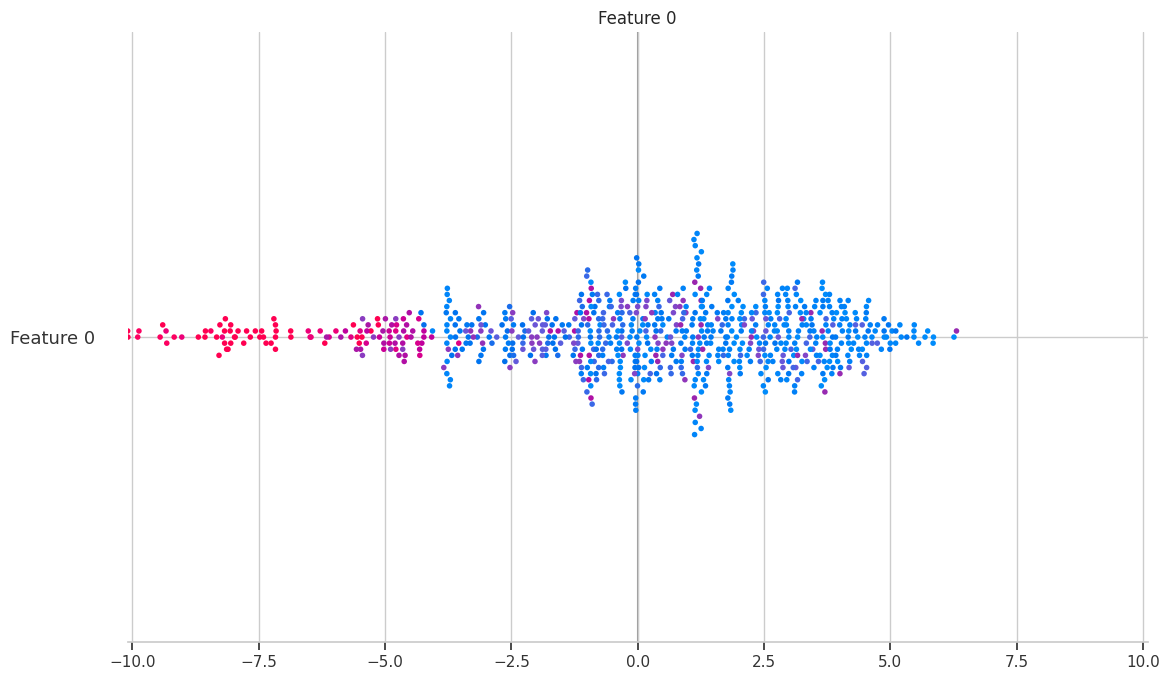

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test, plot_type="dot", show=True)

plt.tight_layout()
plt.show()

<Figure size 1200x1000 with 0 Axes>

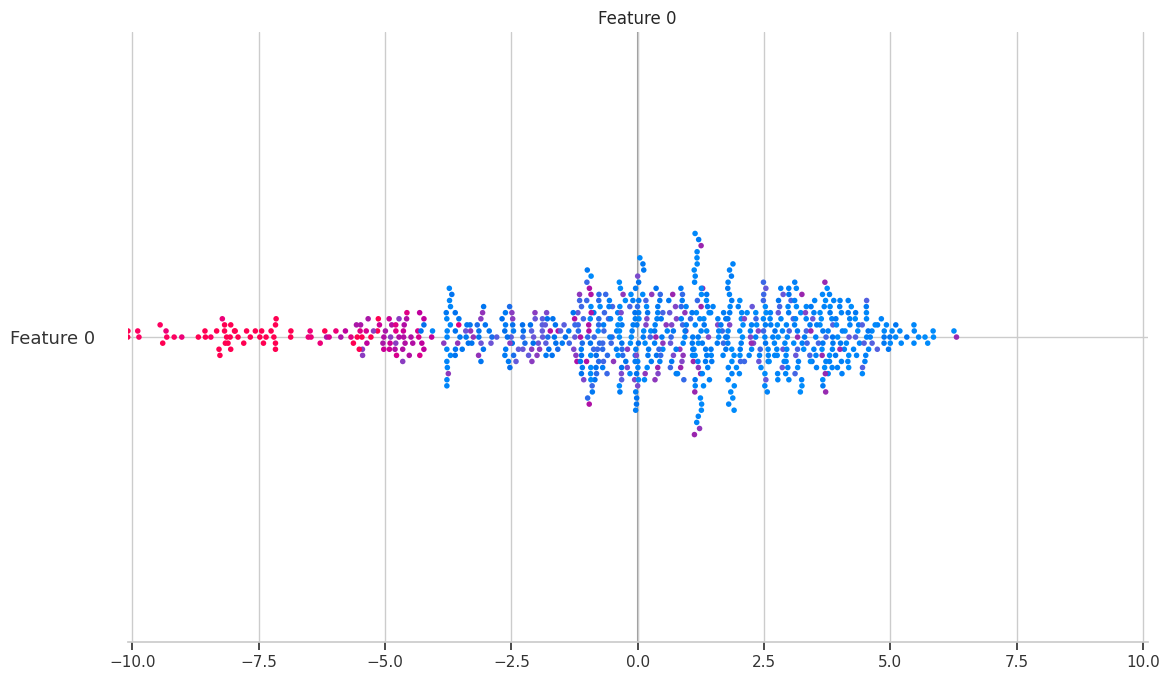

In [ ]:
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_test, plot_type="dot", show=True)

<Figure size 640x480 with 0 Axes>

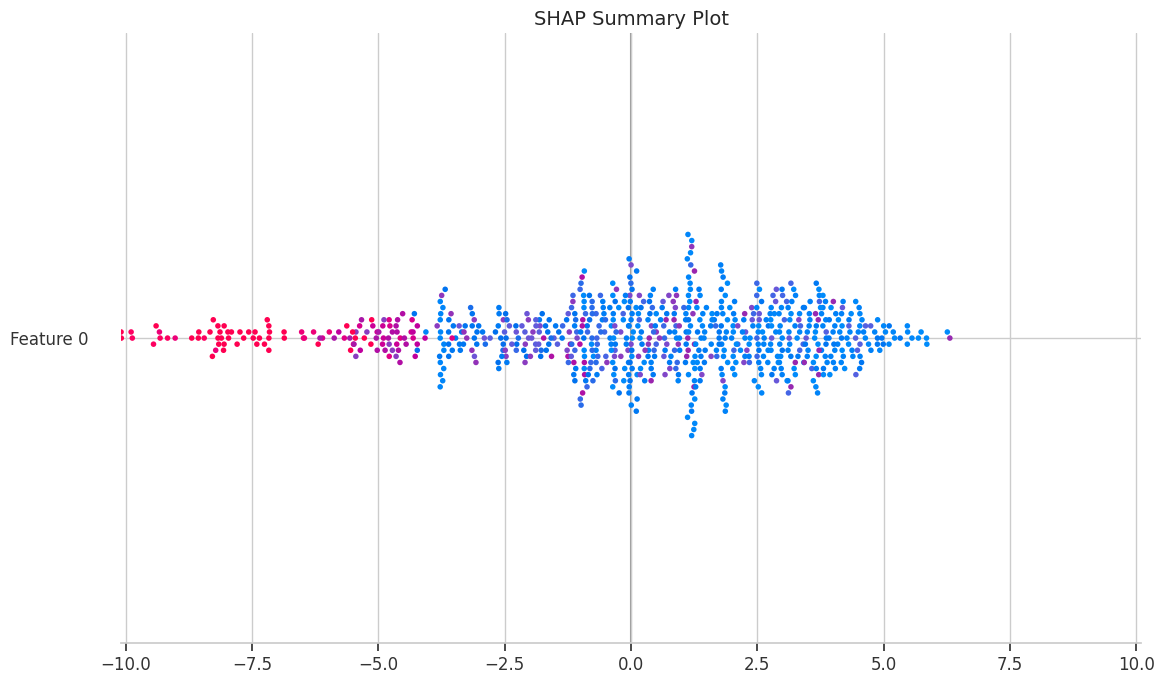

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="dot", show=False)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("SHAP Summary Plot", fontsize=14)
plt.show()

<Figure size 1200x1000 with 0 Axes>

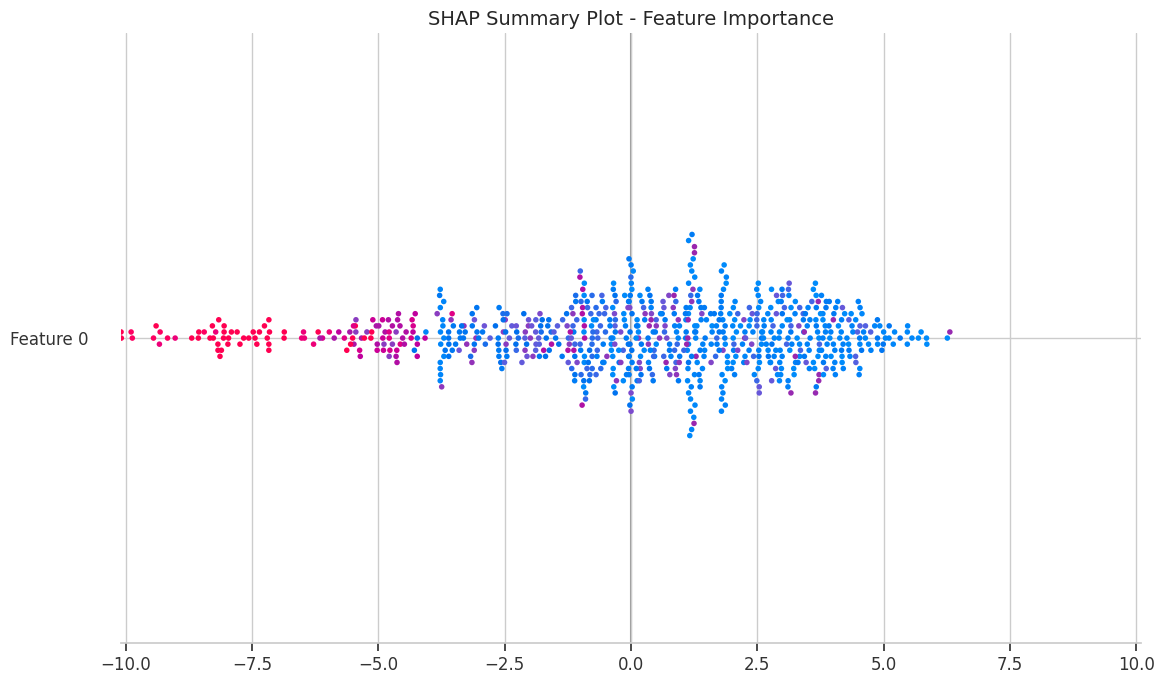

<Figure size 640x480 with 0 Axes>

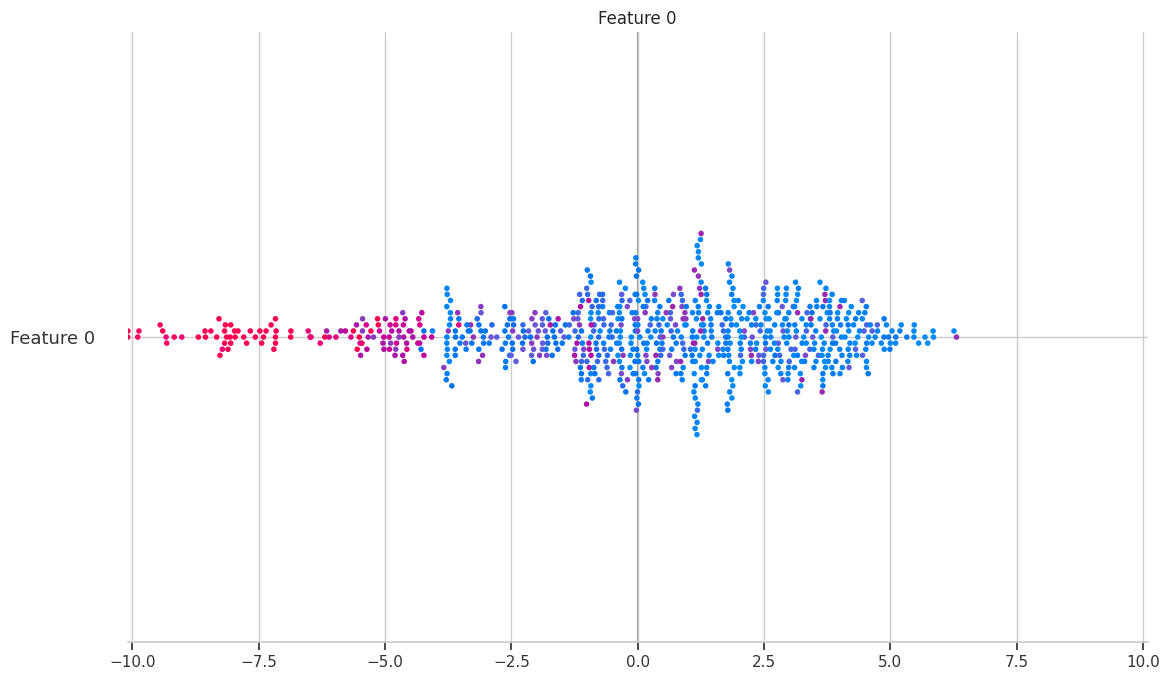

<Figure size 640x480 with 0 Axes>

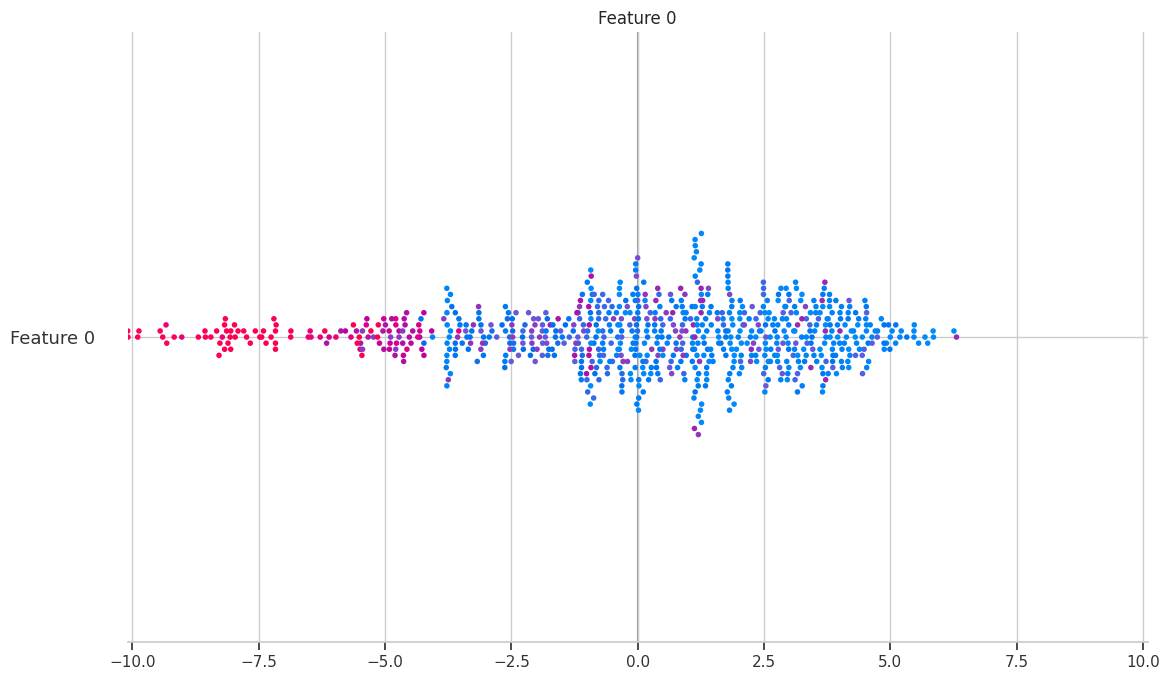

In [ ]:
import shap
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_test, plot_type="dot", show=False)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("SHAP Summary Plot - Feature Importance", fontsize=14)
plt.show()

shap.initjs()
shap.summary_plot(shap_values, X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar", show=True)

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import Dense

X = df_players_with_club_info[['Total Wage', 'Delta_Anomalies', 'Wage', 'Age', 'Apps', 'Caps']]
y = df_players_with_club_info['Place ']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2010)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = Sequential()

model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=500, batch_size=32, verbose=1)

y_pred_dl = model.predict(X_test)

mae_dl = mean_absolute_error(y_test, y_pred_dl)
mse_dl = mean_squared_error(y_test, y_pred_dl)
r2_dl = r2_score(y_test, y_pred_dl)

print(f"Deep Learning Model - MAE: {mae_dl}, MSE: {mse_dl}, R-squared: {r2_dl}")

def model_predict(x):
    return model.predict(x)

explainer = shap.KernelExplainer(model_predict, X_train)

shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

Epoch 1/500


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 86.1592
Epoch 2/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25.8612
Epoch 3/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23.0788
Epoch 4/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.9143
Epoch 5/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.5989
Epoch 6/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.3664
Epoch 7/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.3679
Epoch 8/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.8998
Epoch 9/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.4686
Epoch 10/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15.9239
Epoch 11/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15.9713
Epoch 12/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15.4425
Epoch 13/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15.2812
Epoch 14/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13.8775
Epoch 15/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14.5292
E

  0%|          | 0/782 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6055/6055 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
6055/6055 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
6055/6055 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
6055/6055 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
6055/6055 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
6055/6055 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
6055/6055 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
6055/6055 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
6055/6055 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
6055/6055 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
6055/6055 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
6055/6055 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

KeyboardInterrupt: 

##Final dataset transformation

In [ ]:
df_teams_with_anomalies

,Club,League,Total Wage,Place,Points,plus-minus,Predicted Place,Normal_Anomaly,LogNormal_Anomaly,Total_Anomalies
0,Man City,Premier League,171995000,1,93,73,1.252854,38,38,76
1,Liverpool,Premier League,184684000,2,92,68,1.243289,51,51,102
2,Chelsea,Premier League,229318000,3,74,43,2.277485,54,54,108
3,Tottenham,Premier League,122478000,4,71,29,3.036347,43,43,86
4,Arsenal,Premier League,105908000,5,69,13,3.953909,40,40,80
...,...,...,...,...,...,...,...,...,...,...
111,VIZ,Primiera Liga,2694250,14,33,-21,14.759841,57,57,114
112,Arouca,Primiera Liga,2165000,15,31,-24,15.609671,27,27,54
113,Casa Pia,Primiera Liga,2570250,16,29,-18,15.027032,30,30,60
114,Chaves,Primiera Liga,2623000,17,28,-26,16.520285,23,23,46


In [ ]:
# Assuming `df_club_info` has columns like 'Club', 'League', 'Country'
# Assuming `df_players` has a 'Club' column to join on
df_players = pd.read_excel("/content/players_wage_data.xlsx")

# Merge club information to the player dataset
df_players_with_club_info = df_players.merge(df_teams_with_anomalies, on='Club', how='left')
df_players_with_club_info['Delta_Anomalies'] = df_players_with_club_info['Total_Anomalies'] - df_players_with_club_info['LogNormal_Anomaly']
# Check the first few rows of the merged dataset
df_players_with_club_info.head()

,Wage,Age,Club,League_x,Nation,Position,Apps,Caps,League_y,Total Wage,Place,Points,plus-minus,Predicted Place,Normal_Anomaly,LogNormal_Anomaly,Total_Anomalies,Delta_Anomalies
0,46427000,23,PSG,Ligue 1 Uber Eats,FRA,Forward,190,57,Ligue 1 Uber Eats,220933500,1,86,54,1.529904,20,20,40,20
1,42125000,30,PSG,Ligue 1 Uber Eats,BRA,Midfilder,324,119,Ligue 1 Uber Eats,220933500,1,86,54,1.529904,20,20,40,20
2,34821000,35,PSG,Ligue 1 Uber Eats,ARG,Forward,585,162,Ligue 1 Uber Eats,220933500,1,86,54,1.529904,20,20,40,20
3,19959000,31,R. Madrid,La Liga,BEL,Forward,443,120,La Liga,209962000,1,86,49,1.575327,23,23,46,23
4,19500000,31,Man UFC,Premier League,ESP,Goalkeeper,480,45,Premier League,212620000,6,58,0,6.531924,46,46,92,46


##Additional nice things

In [ ]:
num_players = df_players_with_club_info.shape[0]

# 2. Average salary per player
average_salary = df_players_with_club_info['Wage'].mean()

# Output the results
print(f"Number of players in the dataset: {num_players}")
print(f"Average salary per player: {average_salary:.2f}")

Number of players in the dataset: 3907
Average salary per player: 1367959.37


In [ ]:
# 1. Calculate the number of players per team
players_per_team = df_players_with_club_info.groupby('Club').size()

# 2. Calculate the average salary per player per team
average_salary_per_team = df_players_with_club_info.groupby('Club')['Wage'].mean()

# 3. Calculate the average number of players across all teams
avg_players_per_team = players_per_team.mean()

# 4. Calculate the average salary per player across all teams
avg_salary_per_player_in_team = average_salary_per_team.mean()

# Output the results
print(f"Average number of players per team: {avg_players_per_team:.2f}")
print(f"Average salary per player in a team: {avg_salary_per_player_in_team:.2f}")

Average number of players per team: 33.68
Average salary per player in a team: 1414699.68


In [ ]:
35276000/33

1068969.696969697

In [ ]:
1414699.68/1068969.696969697

1.323423558226556

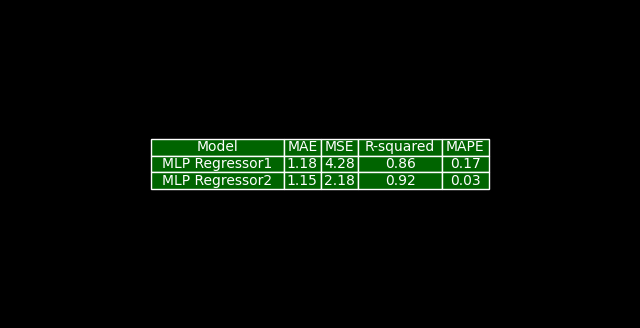

In [ ]:

# Define the data for the table
data = {
    "Model": ["MLP Regressor1", "MLP Regressor2"],
    "MAE": [1.18, 1.15],
    "MSE": [4.28, 2.18],
    "R-squared": [0.86, 0.92],
    "MAPE": [0.17, 0.03],

}

# Create DataFrame from the data
df = pd.DataFrame(data)

# Create a figure and axis for displaying the table
fig, ax = plt.subplots(figsize=(8, 4))

# Hide axes (since we only need the table)
ax.axis("off")

# Create table using the data and set the colors for table styling
table = ax.table(cellText=df.values, colLabels=df.columns, loc="center", cellLoc='center', colColours=["#006400"]*6)

# Apply custom styling (dark green background for the entire table)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width([0, 1, 2, 3, 4, 5])

# Color for the table rows and headers (dark green background and white text)
for (i, j), cell in table.get_celld().items():
    cell.set_text_props(color='white')  # White text for all cells
    cell.set_facecolor('#006400')  # Dark green background for the entire table
    cell.set_edgecolor('white')  # White borders for the cells

# Show the table
plt.show()

In [ ]:
data = {
    'Year': [2013, 2014, 2015, 2016, 2019, 2020, 2021, 2022, 2023],
    'Top-6 leagues transfer market spendings': [3.3, 3.8, 4.3, 5.1, 5.3, 7.35, 4.2, 4.8, 6.1, 7.3, 8.1],
}

df = pd.DataFrame(data)

df.set_index('Year', inplace=True)

styled_df = df.style.background_gradient(cmap='Greens')

styled_df

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, palette='Greens', linewidth=3)

plt.title('Transfer Market Spending of Top-6 Football Leagues (2013-2023)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Spending (in Billions €)', fontsize=12)
plt.show()

SyntaxError: incomplete input (<ipython-input-159-8edc5502025b>, line 25)

Basic Statistics:
         Total Wage  Delta_Anomalies          Wage          Age         Apps  \
count  3.907000e+03      3907.000000  3.907000e+03  3907.000000  3907.000000   
mean   4.837793e+07        36.278219  1.367959e+06    24.120553   140.057077   
std    5.301274e+07        10.084723  2.589857e+06     4.935638   131.694425   
min    2.165000e+06        18.000000  1.400000e+03    18.000000     0.000000   
25%    1.206500e+07        29.000000  7.550000e+04    20.000000    15.000000   
50%    2.704950e+07        35.000000  3.990000e+05    24.000000   115.000000   
75%    6.998650e+07        42.000000  1.560000e+06    28.000000   224.500000   
max    2.293180e+08        64.000000  4.642700e+07    41.000000   715.000000   

              Caps      Place   Predicted Place  Normal_Anomaly  \
count  3907.000000  3907.00000      3907.000000     3907.000000   
mean      8.926542    10.06066         9.986901       36.278219   
std      20.518234     5.53175         5.388796       10.084

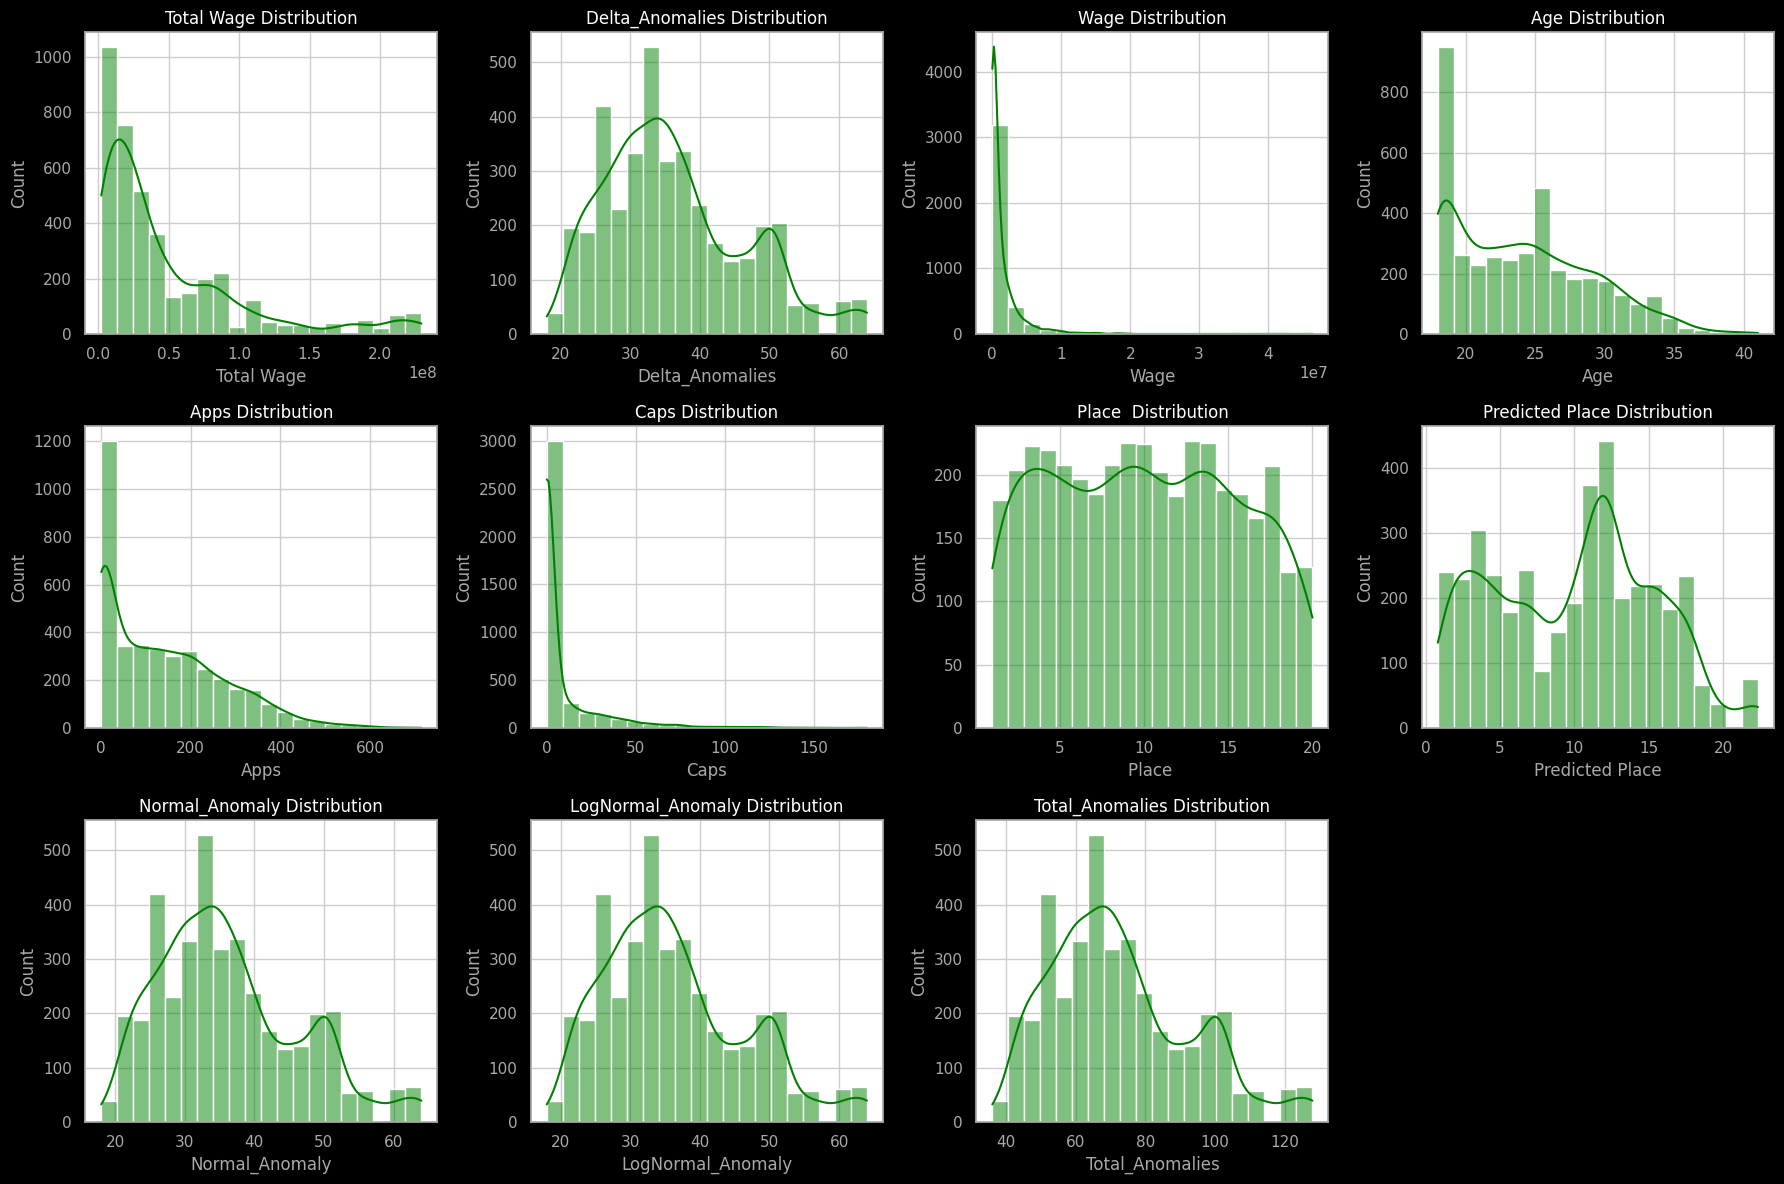

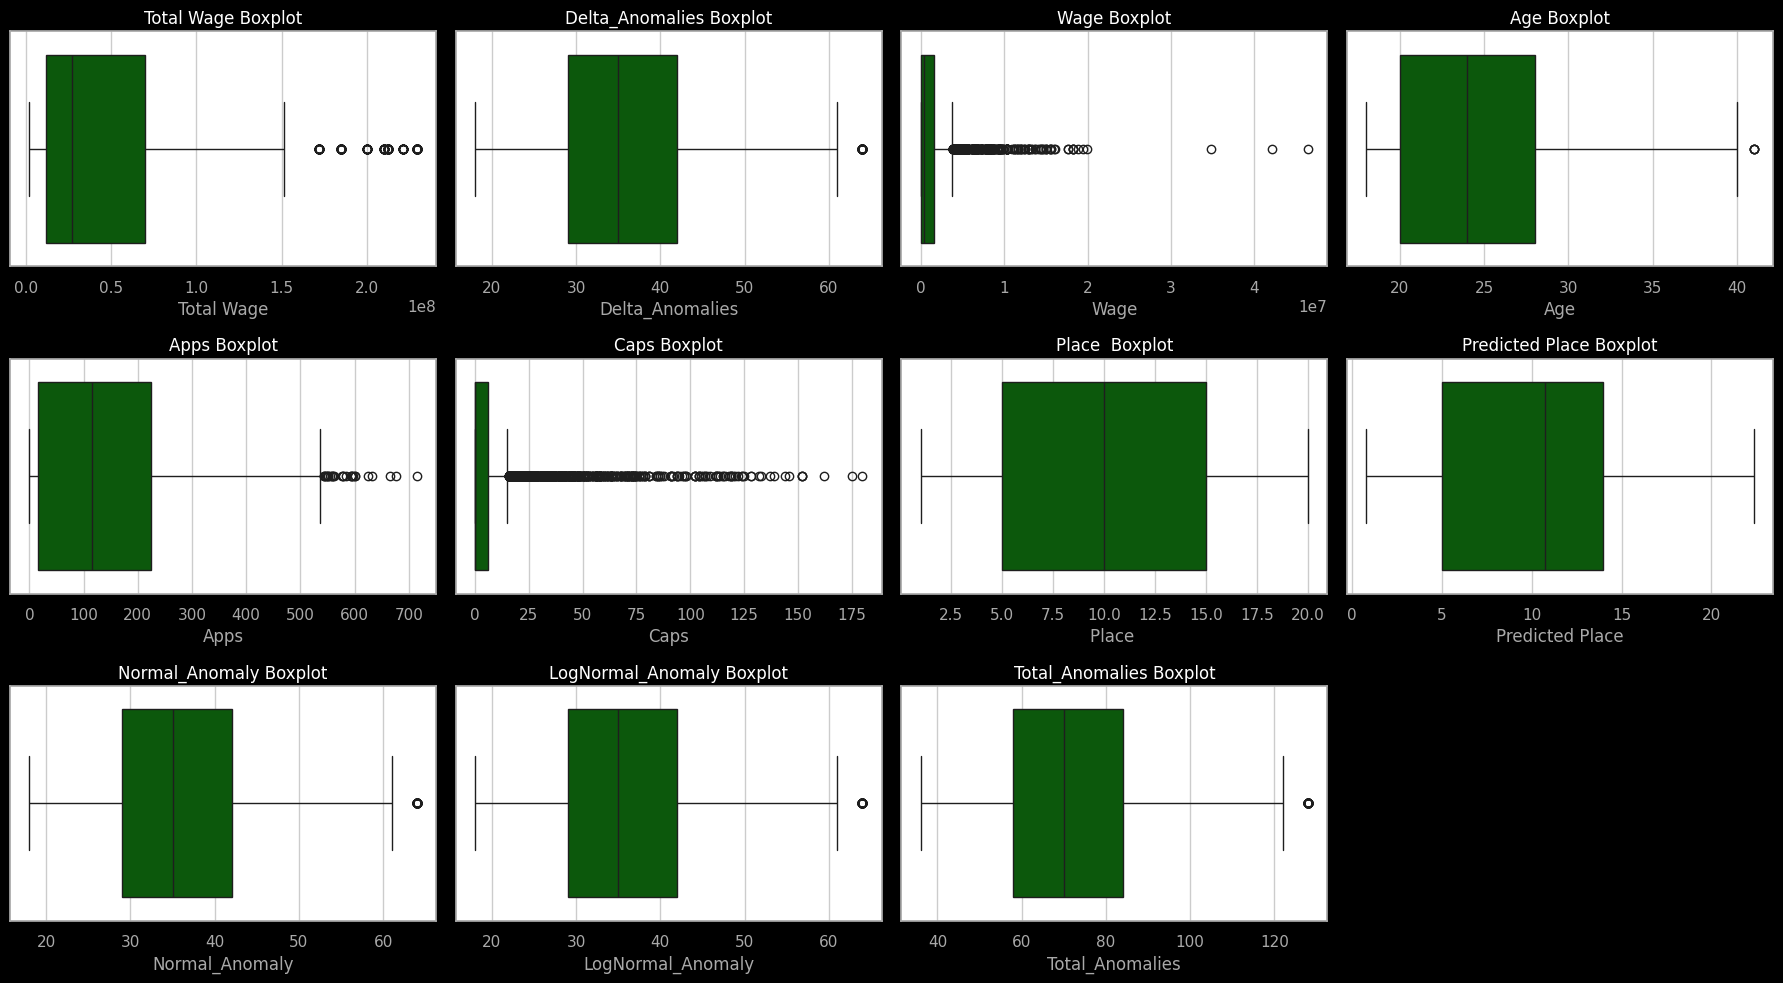

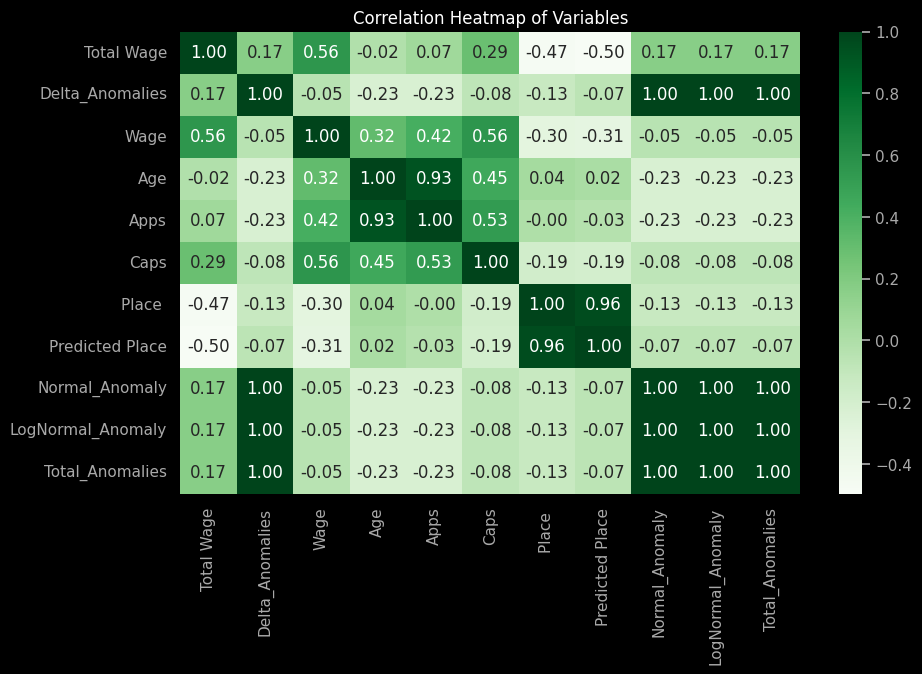

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis

sns.set_palette("Greens")
plt.rcParams.update({
    'axes.facecolor': 'white',
    'figure.facecolor': 'black',
    'axes.edgecolor': 'darkgrey',
    'axes.labelcolor': 'darkgrey',
    'xtick.color': 'darkgrey',
    'ytick.color': 'darkgrey',
    'text.color': 'white'
})

numerical_columns = ['Total Wage', 'Delta_Anomalies', 'Wage', 'Age', 'Apps', 'Caps', 'Place ', 'Predicted Place', 'Normal_Anomaly', 'LogNormal_Anomaly', 'Total_Anomalies']

stats = df_players_with_club_info[numerical_columns].describe()

skewness = df_players_with_club_info[numerical_columns].apply(lambda x: skew(x.dropna()))
kurt = df_players_with_club_info[numerical_columns].apply(lambda x: kurtosis(x.dropna()))

print("Basic Statistics:")
print(stats)
print("\nSkewness:")
print(skewness)
print("\nKurtosis:")
print(kurt)

plt.figure(figsize=(18, 12))

for i, column in enumerate(numerical_columns, 1):
    plt.subplot(3, 4, i)
    sns.histplot(df_players_with_club_info[column], kde=True, color='green', bins=20)
    plt.title(f'{column} Distribution', color='white')

plt.tight_layout()
plt.show()

plt.figure(figsize=(18, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(3, 4, i)
    sns.boxplot(x=df_players_with_club_info[column], color='darkgreen')
    plt.title(f'{column} Boxplot', color='white')

plt.tight_layout()
plt.show()

correlation_matrix = df_players_with_club_info[numerical_columns].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='Greens', fmt='.2f', cbar=True)
plt.title('Correlation Heatmap of Variables', color='white')
plt.show()

<ipython-input-187-63e31441b85c>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax, data=data, x=x_col, y=y_col, palette=[bar_color])
<ipython-input-187-63e31441b85c>:16: UserWarning: 
The palette list has fewer values (1) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(ax=ax, data=data, x=x_col, y=y_col, palette=[bar_color])
<ipython-input-187-63e31441b85c>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax, data=data, x=x_col, y=y_col, palette=[bar_color])
<ipython-input-187-63e31441b85c>:16: UserWarning: 
The palette list has fewer values (1) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(ax=ax

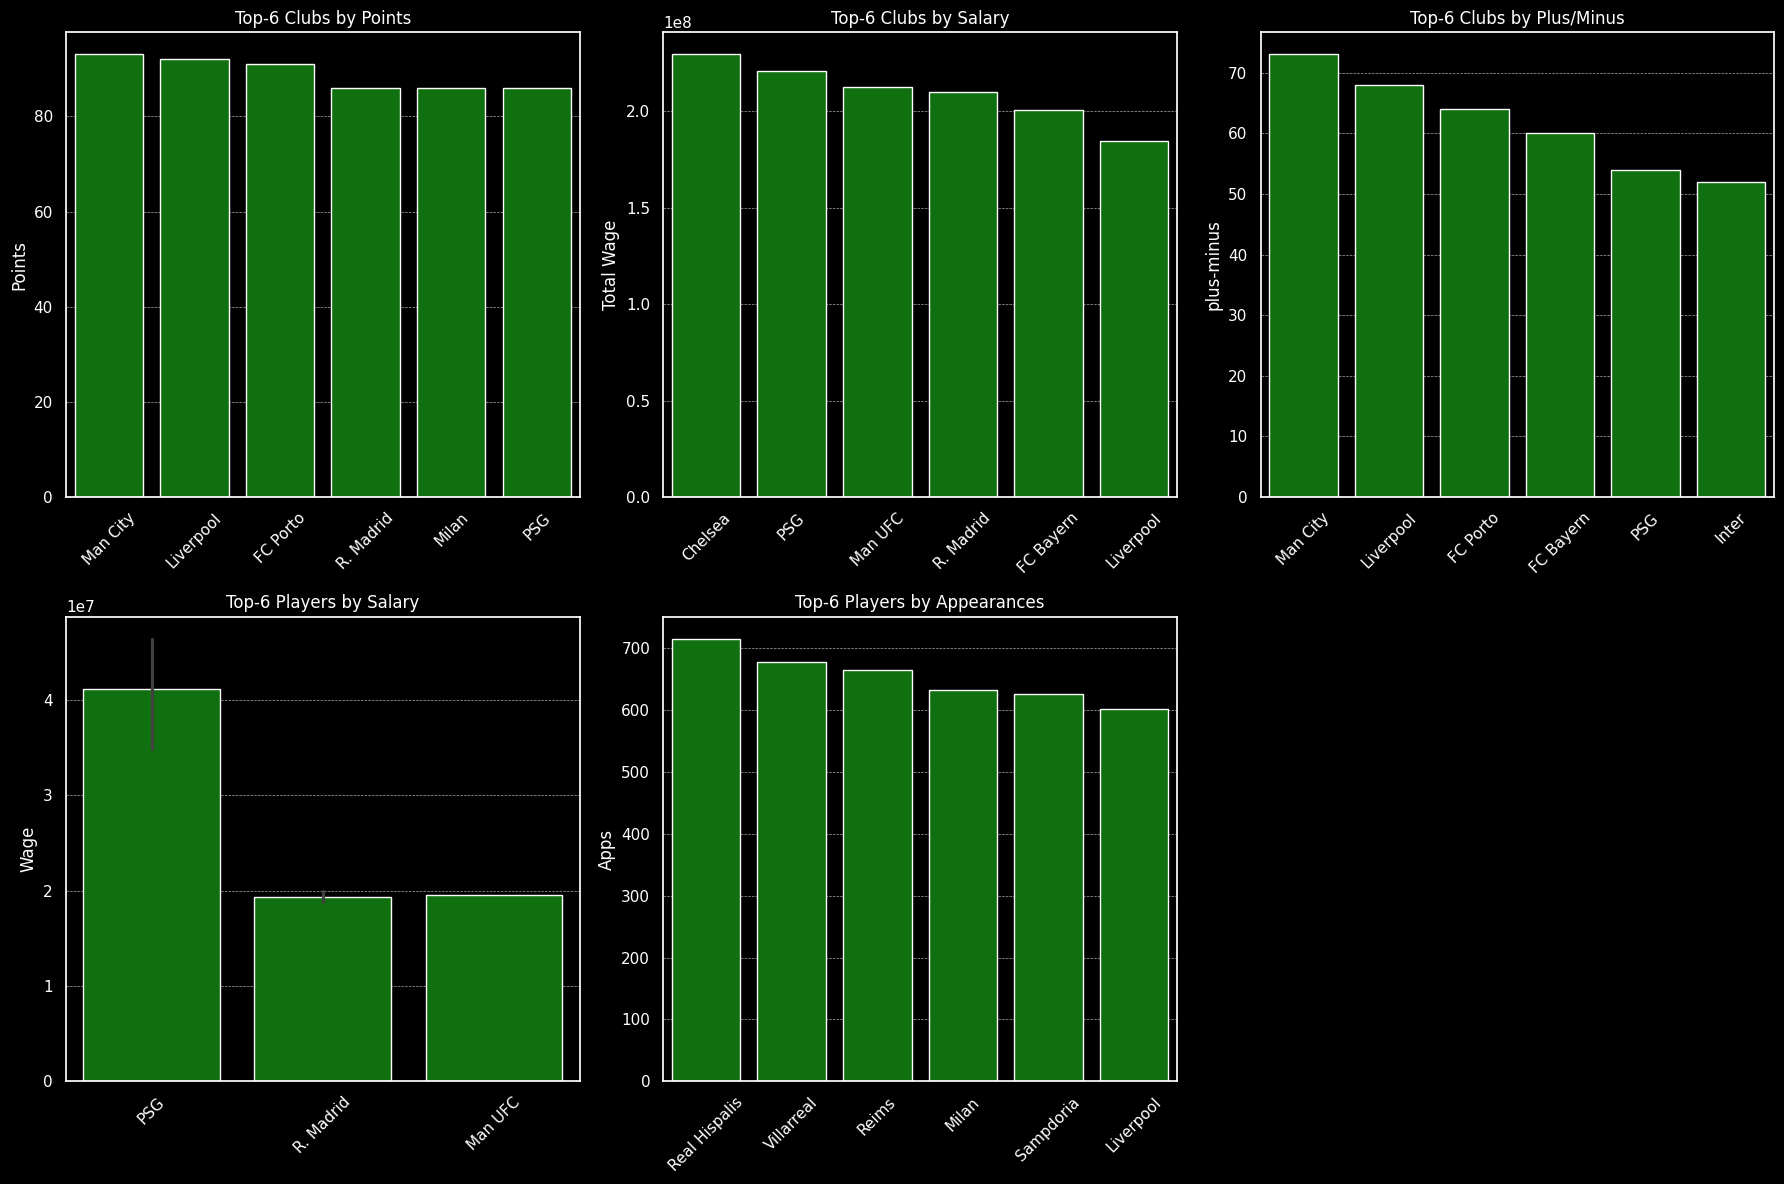

In [ ]:
plt.style.use('dark_background')

bg_color = "black"
bar_color = "green"
text_color = "white"
grid_color = "darkgrey"

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.patch.set_facecolor(bg_color)

def plot_bar_chart(ax, data, x_col, y_col, title):
    sns.barplot(ax=ax, data=data, x=x_col, y=y_col, palette=[bar_color])
    ax.set_title(title, color=text_color)
    ax.set_xlabel("")
    ax.set_ylabel(y_col, color=text_color)
    ax.tick_params(axis='x', rotation=45, colors=text_color)
    ax.tick_params(axis='y', colors=text_color)
    ax.set_facecolor(bg_color)
    ax.grid(axis='y', linestyle='--', linewidth=0.5, color=grid_color)

top_6_clubs = df_teams.nlargest(6, "Points")
plot_bar_chart(axes[0, 0], top_6_clubs, "Club", "Points", "Top-6 Clubs by Points")

top_6_salaries = df_teams.nlargest(6, "Total Wage")
plot_bar_chart(axes[0, 1], top_6_salaries, "Club", "Total Wage", "Top-6 Clubs by Salary")

top_6_plus_minus = df_teams.nlargest(6, "plus-minus")
plot_bar_chart(axes[0, 2], top_6_plus_minus, "Club", "plus-minus", "Top-6 Clubs by Plus/Minus")

top_6_players_salaries = df_players.nlargest(6, "Wage")
plot_bar_chart(axes[1, 0], top_6_players_salaries, "Club", "Wage", "Top-6 Players by Salary")

top_6_players_apps = df_players.nlargest(6, "Apps")
plot_bar_chart(axes[1, 1], top_6_players_apps, "Club", "Apps", "Top-6 Players by Appearances")

axes[1, 2].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
selected_columns = ["Wage", "Age", "Apps", "Caps",
                    "Total Wage", "Place ", "Points", "plus-minus", "Predicted Place",
                    "Normal_Anomaly", "LogNormal_Anomaly", "Total_Anomalies", "Delta_Anomalies"]

df_selected = df_players_with_club_info[selected_columns].head(20)

def style_table(s):
    return [
        {"selector": "thead", "props": [("background-color", "darkgrey"), ("color", "white"), ("font-weight", "bold")]},
        {"selector": "tbody", "props": [("color", "white"), ("background-color", "black")]},
        {"selector": "th", "props": [("background-color", "green"), ("color", "black"), ("font-weight", "bold")]}
    ]

styled_table = df_selected.style.set_table_styles(style_table(df_selected))\
                               .set_properties(**{'color': 'white', 'border-color': 'darkgrey'})\
                               .set_caption("⚽ Football Player Dataset Overview")

styled_table

,Wage,Age,Apps,Caps,Total Wage,Place,Points,plus-minus,Predicted Place,Normal_Anomaly,LogNormal_Anomaly,Total_Anomalies,Delta_Anomalies
0,46427000,23,190,57,220933500,1,86,54,1.168121,20,20,40,20
1,42125000,30,324,119,220933500,1,86,54,1.168121,20,20,40,20
2,34821000,35,585,162,220933500,1,86,54,1.168121,20,20,40,20
3,19959000,31,443,120,209962000,1,86,49,1.239110,23,23,46,23
4,19500000,31,480,45,212620000,6,58,0,6.029303,46,46,92,46
5,18810000,30,371,94,209962000,1,86,49,1.239110,23,23,46,23
6,18200000,29,427,102,115556000,2,84,52,2.003689,32,32,64,32
7,18200000,30,367,85,184684000,2,92,68,1.243289,51,51,102,51
8,18200000,27,326,77,229318000,3,74,43,2.277485,54,54,108,54
9,18200000,29,287,86,212620000,6,58,0,6.029303,46,46,92,46


In [ ]:
variables_data = {
    "Variable": [
        "Wage", "Age", "Apps", "Caps",
        "Total Wage", "Place ", "Points", "plus-minus", "Predicted Place",
        "Normal_Anomaly", "LogNormal_Anomaly", "Total_Anomalies", "Delta_Anomalies"
    ],
    "Description": [
        "Individual wage of the player",
        "Age of the player",
        "Total appearances in matches",
        "Total international caps",
        "Total wage expenditure of the club",
        "Final placement of the club in the league",
        "Total points achieved in the season",
        "Goal difference (plus/minus) of the club",
        "Predicted league placement from the model",
        "Anomaly detection based on normal distribution",
        "Anomaly detection based on log-normal distribution",
        "Total number of detected anomalies",
        "Delta of normally distributed anomalies and total number"
    ]
}

df_variables = pd.DataFrame(variables_data)

styled_table = df_variables.style\
    .set_table_styles([
        {"selector": "thead", "props": [("background-color", "darkgreen"), ("color", "white"), ("font-weight", "bold"), ("border", "1px solid white")]},
        {"selector": "tbody", "props": [("background-color", "darkgreen"), ("color", "white"), ("border", "1px solid white")]},
        {"selector": "td, th", "props": [("background-color", "darkgreen"), ("color", "white"), ("border", "1px solid white"), ("text-align", "left")]}
    ])\
    .set_properties(**{"background-color": "darkgreen", "color": "white", "border-color": "white"})\
    .set_caption("⚽ Dataset Variables and Descriptions")

styled_table

,Variable,Description
0,Wage,Individual wage of the player
1,Age,Age of the player
2,Apps,Total appearances in matches
3,Caps,Total international caps
4,Total Wage,Total wage expenditure of the club
5,Place,Final placement of the club in the league
6,Points,Total points achieved in the season
7,plus-minus,Goal difference (plus/minus) of the club
8,Predicted Place,Predicted league placement from the model
9,Normal_Anomaly,Anomaly detection based on normal distribution
